<a href="https://colab.research.google.com/github/dho619/TCC_Pos_IA/blob/main/Algoritmo_RandonForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [6]:
#Para documentação de passo a passo e justificativa dessa função, pode encontrá-la no arquivo TratamentoDosDados.ipynb
def TratarDadosBaseWalmart(df):
  df.Date=pd.to_datetime(df.Date, format='%d-%m-%Y')
  df['Day'] = df.Date.dt.day
  df['Month'] = df.Date.dt.month
  df['Year'] = df.Date.dt.year
  df.drop(['Date'], axis=1, inplace=True)

  df.drop_duplicates(inplace=True)

  ignoreFeatures = ['Weekly_Sales', 'Day']
  maximumToBeCategorical = 45
  features = [i for i in df.columns if i not in ignoreFeatures]
  uniqueValuesForFeature = df[features].nunique().sort_values()
  categoricalFeature = [];
  valuesFeature = [];
  for i in range(df[features].shape[1]):
      if uniqueValuesForFeature.values[i]<=maximumToBeCategorical:
          categoricalFeature.append(uniqueValuesForFeature.index[i])
      else:
          valuesFeature.append(uniqueValuesForFeature.index[i])
  for i in categoricalFeature:
    if df[i].nunique()==2:
        df[i]=pd.get_dummies(df[i], drop_first=True, prefix=str(i))
    if (df[i].nunique()>2):
        df = pd.concat([df.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df[i], prefix=str(i)))],axis=1)
    
  return df


In [7]:
#Para documentação de passo a passo e justificativa dessa função, pode encontrá-la no arquivo PreparaçãoDeDados.ipynb

def NormalizarValores(df, columns):
  for column in columns:
    df[column] = df[column]/df[column].max()

def PertenceAMesmaLoja(df, num1, num2):
  if num1 < 0 or num2 < 0: return False
  for i in range(1, 46):
    if df["Store_" + str(i)][num1] != df["Store_" + str(i)][num2]: return False
  return True

def PreparaDados(df, formatoDados):
  target = "Weekly_Sales"

  df["SalesOneWeekAgo"] = np.zeros(len(df[target]))
  df["SalesTwoWeeksAgo"] = np.zeros(len(df[target]))
  df["SalesThreeWeeksAgo"] = np.zeros(len(df[target]))

  for i, sales in enumerate(df[target]):
    df["SalesOneWeekAgo"][i] = df[target][i-1] if PertenceAMesmaLoja(df, i, i-1) else df[target][i]
    df["SalesTwoWeeksAgo"][i] = df[target][i-2] if PertenceAMesmaLoja(df, i, i-2) else df[target][i]
    df["SalesThreeWeeksAgo"][i] = df[target][i-3] if PertenceAMesmaLoja(df, i, i-3) else df[target][i]

  #Normalizando valores
  columns = ["Temperature", "Fuel_Price", "CPI", "Unemployment"]
  NormalizarValores(df, columns)

  filtro_treino = df["Year_2012"] == 0
  filtro_teste = df["Year_2012"] == 1

  train = df.where(filtro_treino).dropna()
  test =  df.where(filtro_teste).dropna()

  y_train = train[target].array
  X_train = train.drop([target, "Year_2010", "Year_2011", "Year_2012"],axis=1)
  
  y_test = test[target].array
  X_test = test.drop([target, "Year_2010", "Year_2011", "Year_2012"],axis=1)

  X_train.reset_index(drop=True,inplace=True)

  return X_train.astype(formatoDados), X_test.astype(formatoDados), y_train.astype(formatoDados), y_test.astype(formatoDados)

In [8]:
df = pd.read_csv('./Walmart.csv')
df = TratarDadosBaseWalmart(df)

X_train, X_test, y_train, y_test = PreparaDados(df, np.float32)

print('Base original  ---> ',df.shape,df.shape,'\nBase de Treino  ---> ',X_train.shape,y_train.shape,'\nBase de teste   ---> ', X_test.shape,'', y_test.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Base original  --->  (6435, 70) (6435, 70) 
Base de Treino  --->  (4500, 66) (4500,) 
Base de teste   --->  (1935, 66)  (1935,)


In [9]:
rf = RandomForestRegressor(random_state=0, min_samples_leaf=25)
rf.fit(X_train, y_train)
#dt = DecisionTreeRegressor(random_state=0, min_samples_leaf=10, max_depth = 44)

predictions = rf.predict(X_test)

In [10]:
r2_score(y_test, predictions), mean_absolute_error(y_test, predictions), np.sqrt(mean_squared_error(y_test, predictions))

(0.9724602946070477, 59572.10767588396, 89035.11551525527)

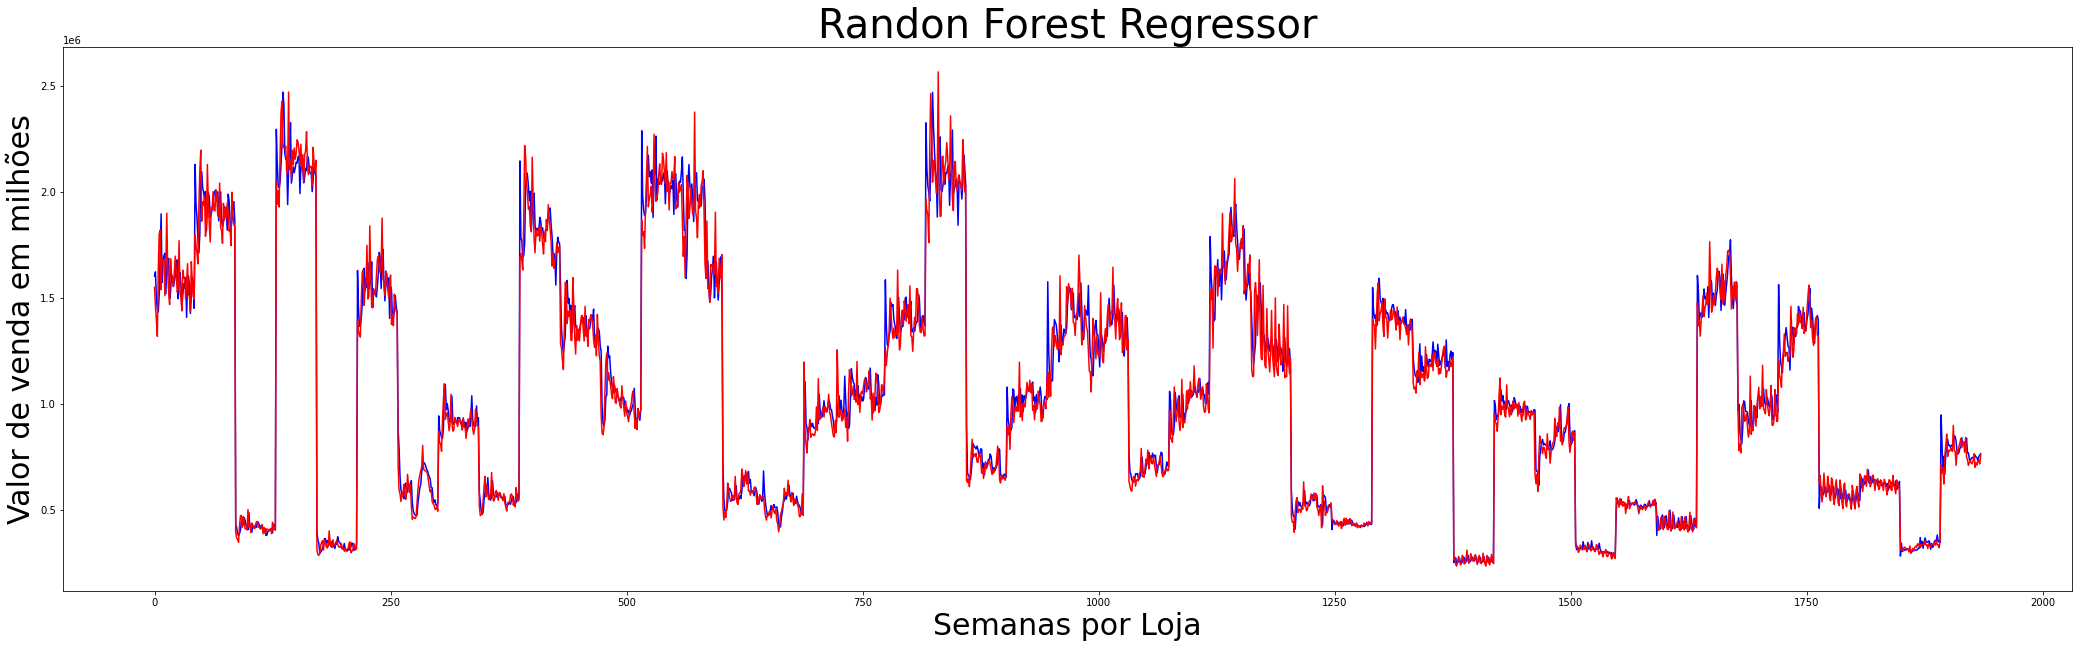

In [11]:
plt.figure(figsize = (36, 10)) 
plt.plot(range(len(predictions)), predictions, 'b')
plt.plot(range(len(predictions)), y_test, 'r')
plt.title("Randon Forest Regressor", fontsize=40)
plt.xlabel("Semanas por Loja", fontsize=30)
plt.ylabel("Valor de venda em milhões", fontsize=30)

plt.show()

In [12]:
for i in range(len(predictions)):
  print("Valor real: {} Valor Predito: {}".format(y_test[i], predictions[i]))
  

Valor real: 1550369.875 Valor Predito: 1603269.5179338485
Valor real: 1459601.125 Valor Predito: 1623243.901190791
Valor real: 1394393.875 Valor Predito: 1494532.3752164638
Valor real: 1319325.625 Valor Predito: 1445385.2789329037
Valor real: 1636339.625 Valor Predito: 1433886.135749093
Valor real: 1802477.375 Valor Predito: 1520579.606671802
Valor real: 1819870.0 Valor Predito: 1712349.7211943907
Valor real: 1539387.875 Valor Predito: 1896442.543538364
Valor real: 1688420.75 Valor Predito: 1573588.572914387
Valor real: 1675431.125 Valor Predito: 1678473.153395322
Valor real: 1677472.75 Valor Predito: 1699695.9422261268
Valor real: 1511068.125 Valor Predito: 1711113.713488404
Valor real: 1649604.625 Valor Predito: 1519267.2591814983
Valor real: 1899676.875 Valor Predito: 1654089.010499739
Valor real: 1621031.75 Valor Predito: 1683556.1063811474
Valor real: 1521577.875 Valor Predito: 1686788.4458460773
Valor real: 1468928.375 Valor Predito: 1495343.5183195465
Valor real: 1684520.0 Valor

In [13]:
for i, feature in enumerate(rf.feature_names_in_):
  print("Feature {}: {}".format(feature, rf.feature_importances_[i]))


Feature Holiday_Flag: 0.00027829568468579733
Feature Temperature: 0.0021395793237269107
Feature Fuel_Price: 0.00040568897672598326
Feature CPI: 0.0008346310640406387
Feature Unemployment: 0.0004361268922406234
Feature Day: 0.006519604916907642
Feature Month_1: 0.0
Feature Month_2: 0.0
Feature Month_3: 0.0
Feature Month_4: 0.0
Feature Month_5: 0.0
Feature Month_6: 0.0
Feature Month_7: 0.0
Feature Month_8: 0.0
Feature Month_9: 1.3514359897641025e-05
Feature Month_10: 0.0
Feature Month_11: 0.0009139129611353572
Feature Month_12: 0.0035091188806895927
Feature Store_1: 0.0
Feature Store_2: 0.0
Feature Store_3: 0.0
Feature Store_4: 0.0
Feature Store_5: 0.0
Feature Store_6: 0.0
Feature Store_7: 0.0
Feature Store_8: 2.731556179496923e-06
Feature Store_9: 0.0
Feature Store_10: 0.0
Feature Store_11: 0.0
Feature Store_12: 0.0
Feature Store_13: 0.0
Feature Store_14: 8.161873979615415e-06
Feature Store_15: 0.0
Feature Store_16: 0.0
Feature Store_17: 5.756968967889393e-07
Feature Store_18: 0.0
Featu

Resultados Loja 1:
-0.23719692725487063 97867.71745086723 126507.9465885176


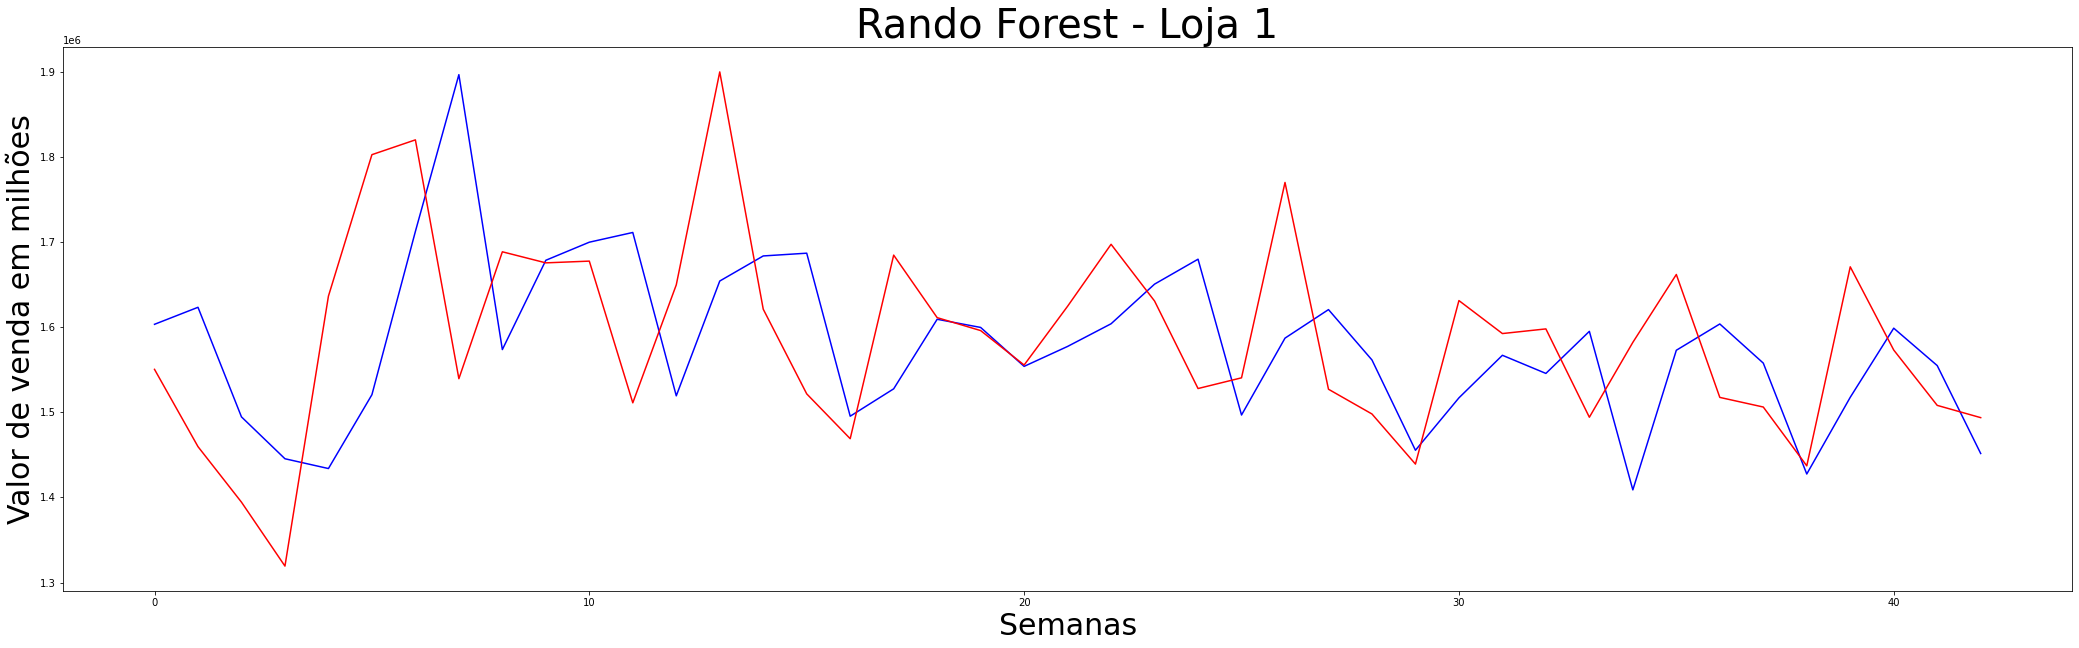

**************************************************
Resultados Loja 2:
-0.3969573201125183 101024.56578529334 126866.39765626768


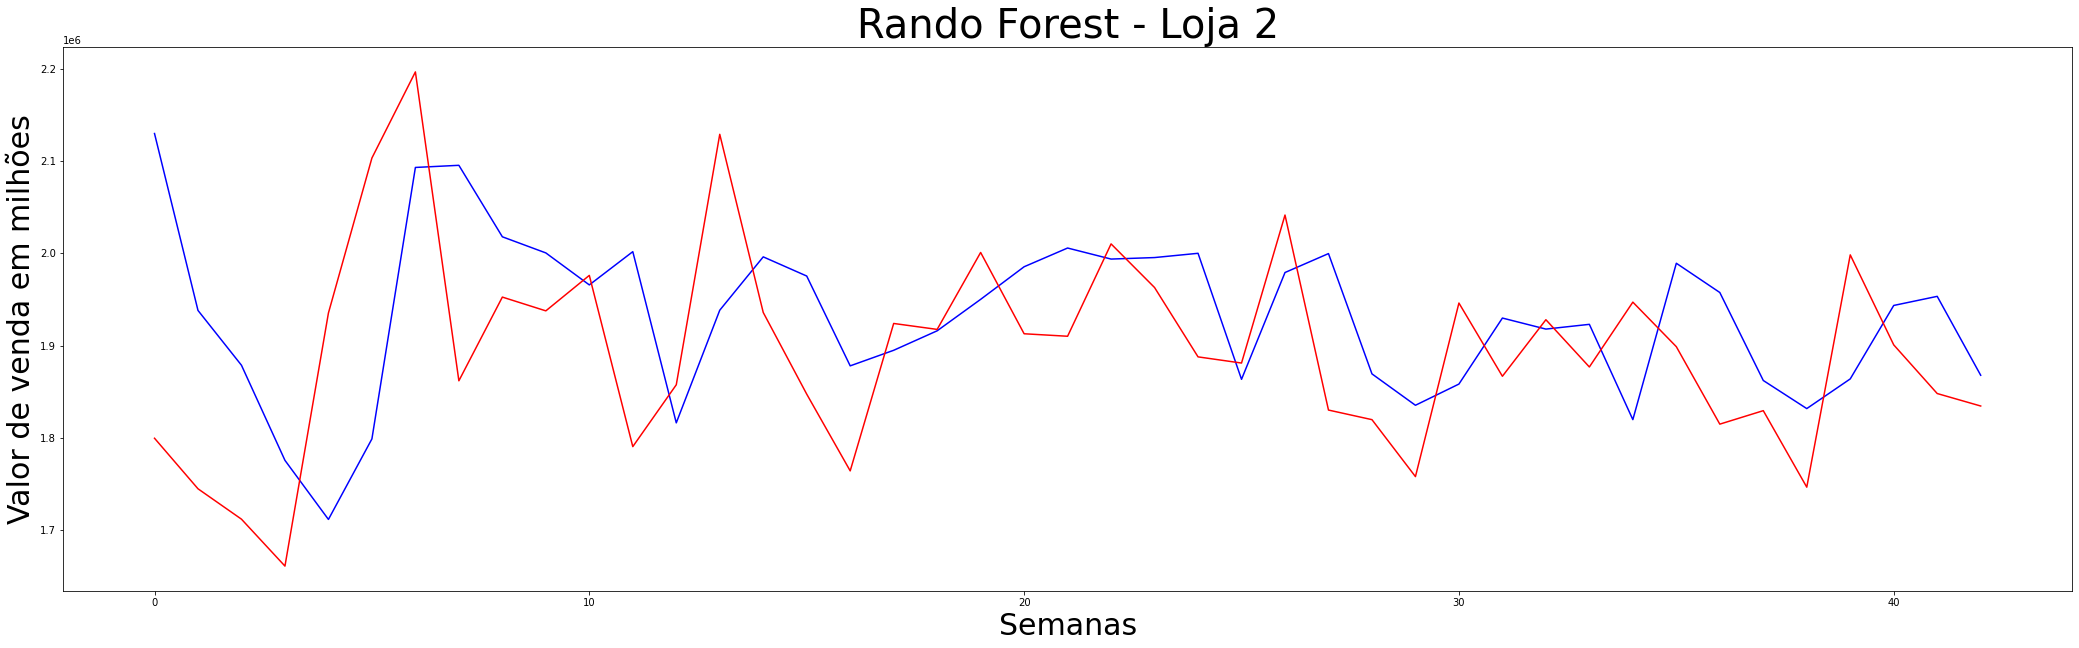

**************************************************
Resultados Loja 3:
-0.23373093938699285 25174.42662823666 31708.75280124888


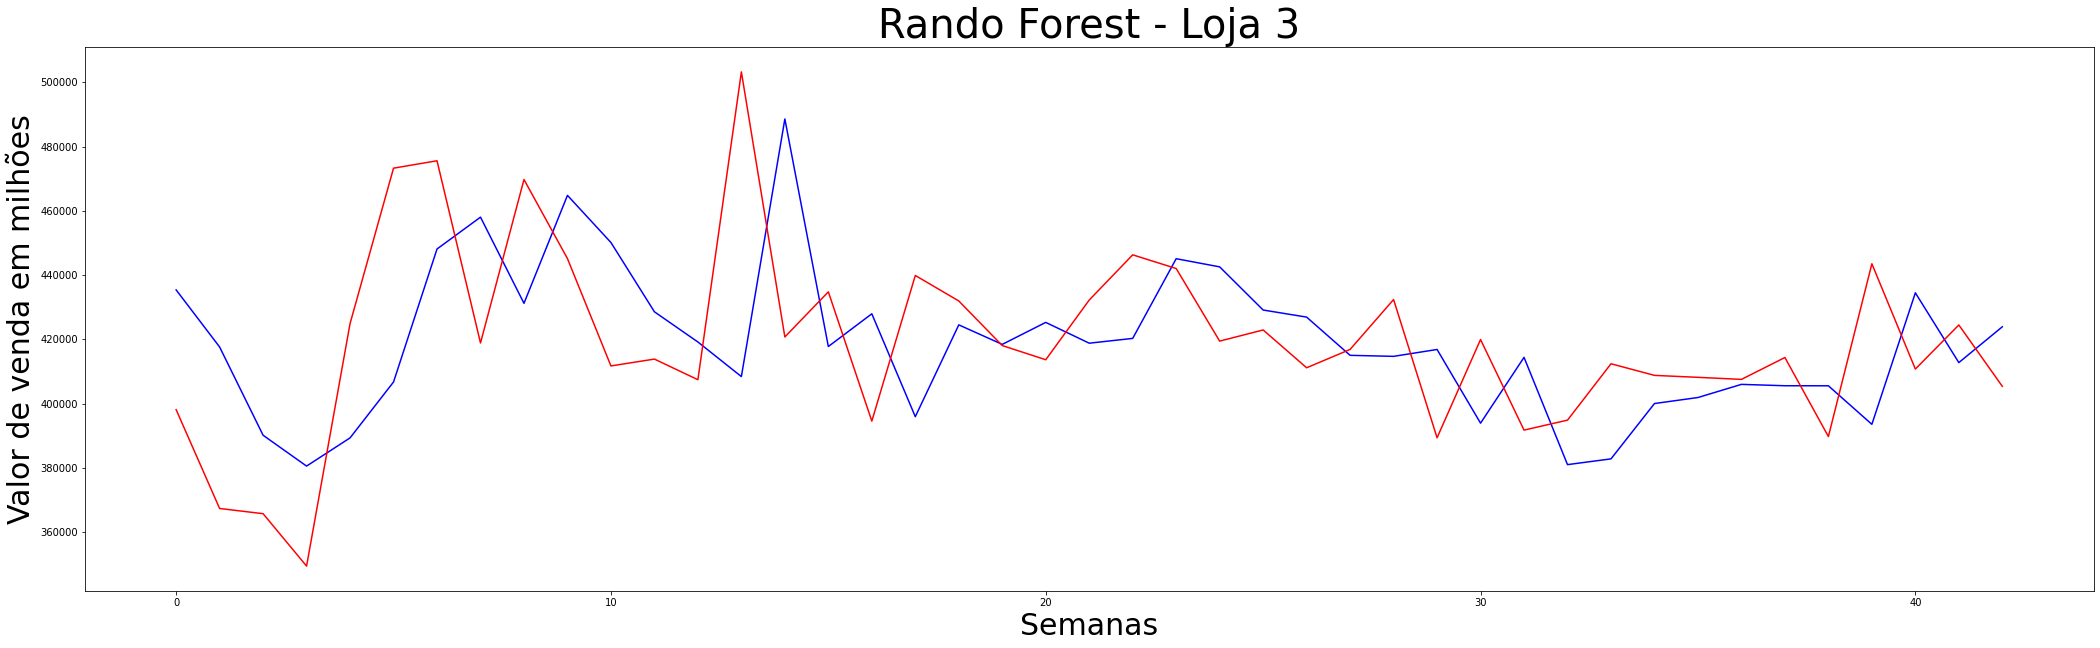

**************************************************
Resultados Loja 4:
-0.47025069770152816 98650.53995641078 127993.43403454126


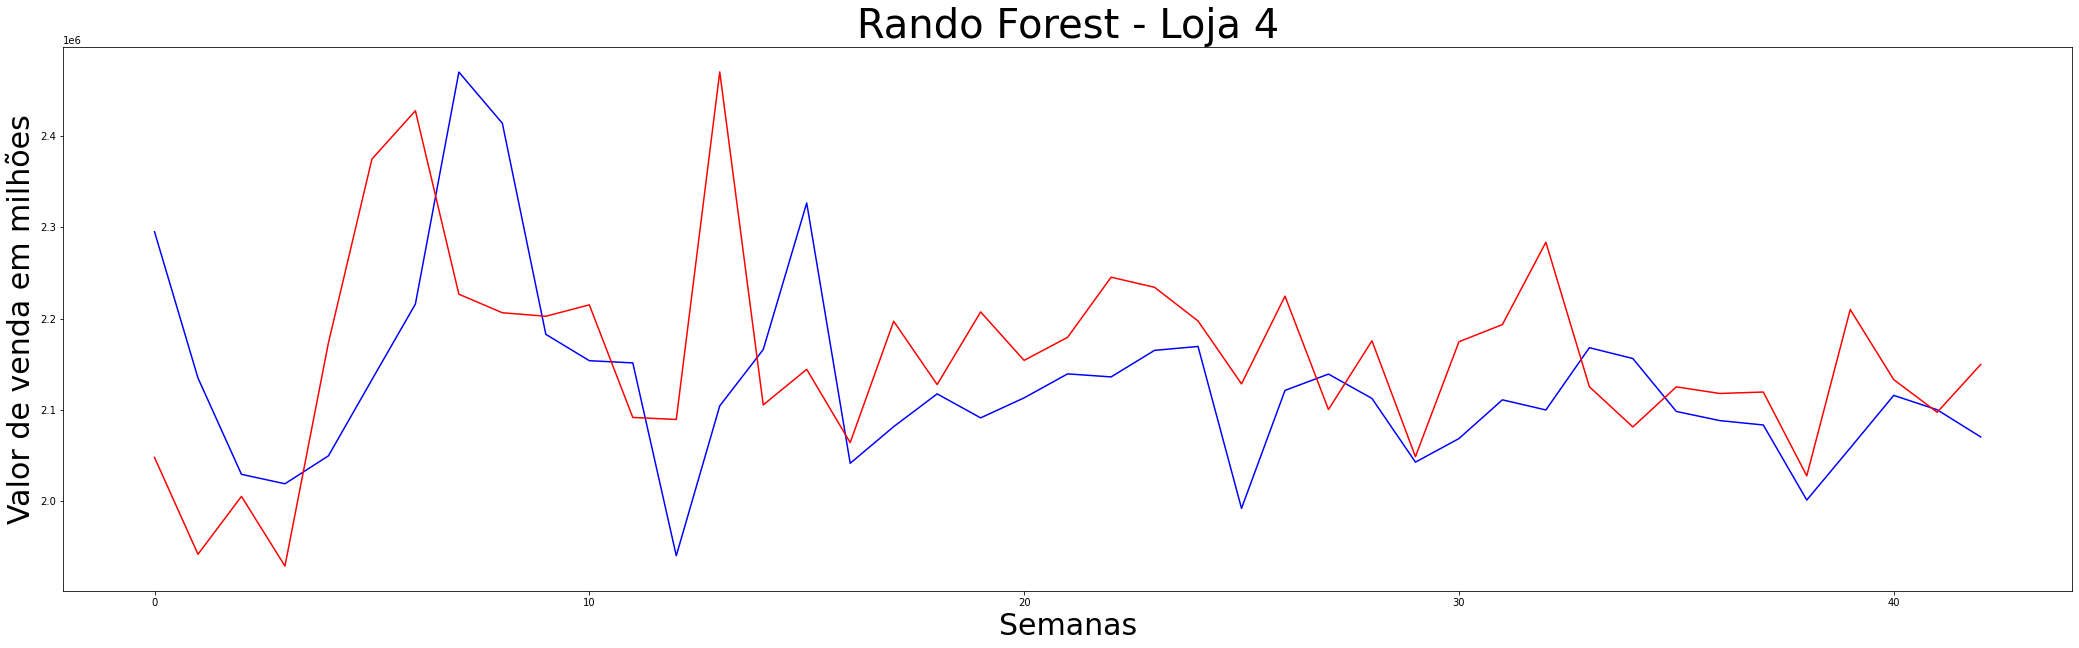

**************************************************
Resultados Loja 5:
-0.7729946136163139 22917.574368203903 29006.267926991517


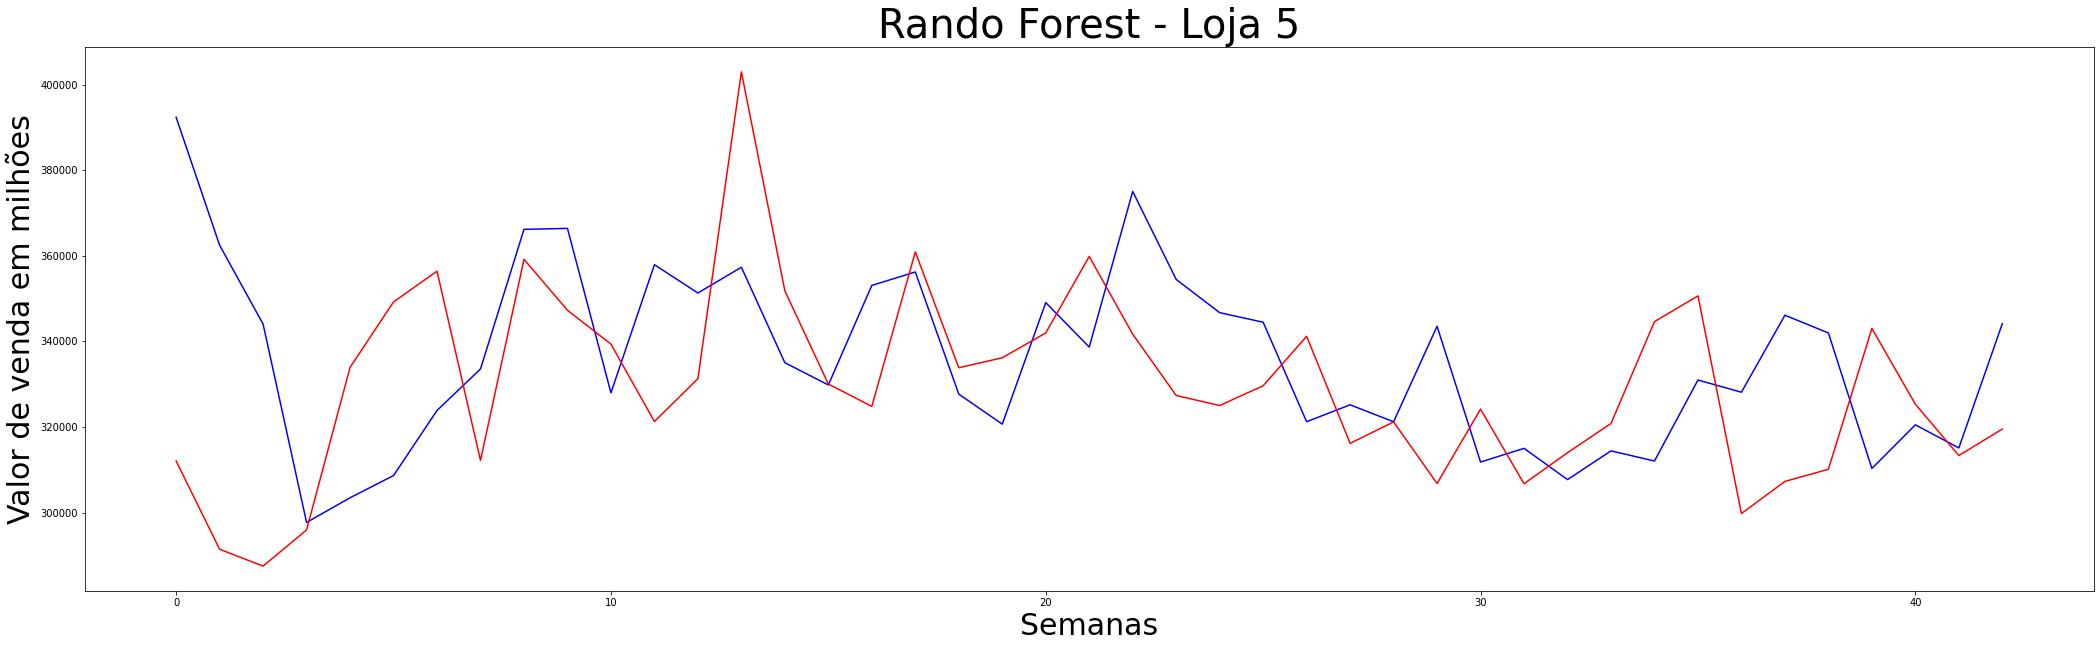

**************************************************
Resultados Loja 6:
0.1712526033064019 84681.00826429849 111645.66575363072


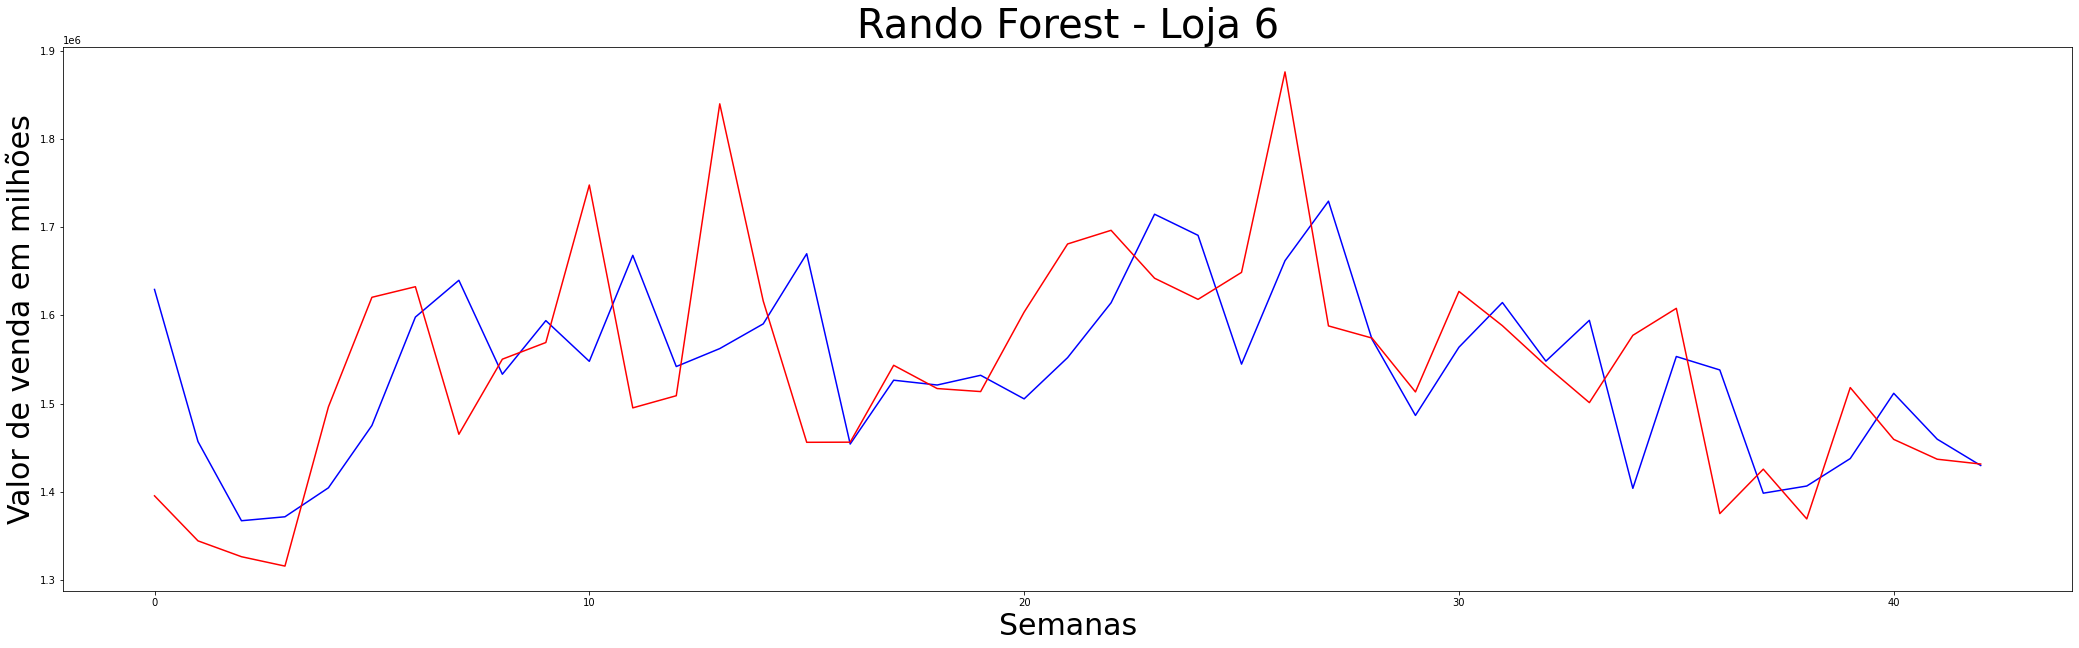

**************************************************
Resultados Loja 7:
0.40034807249472937 46968.17412243819 62769.95533610686


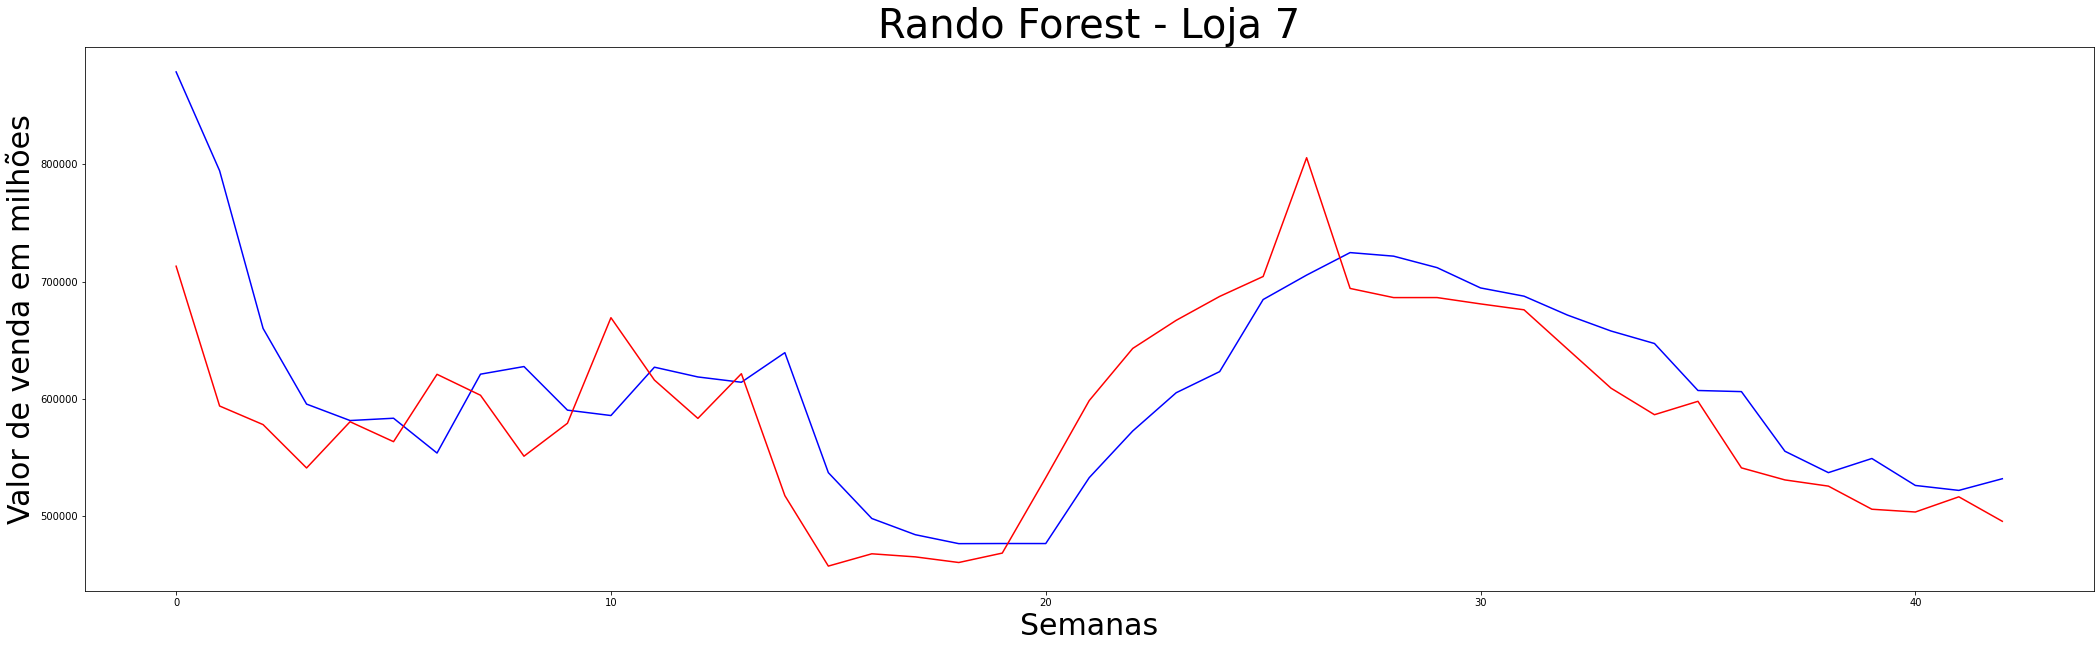

**************************************************
Resultados Loja 8:
-0.11402271947845621 45300.12583531236 59313.06364069042


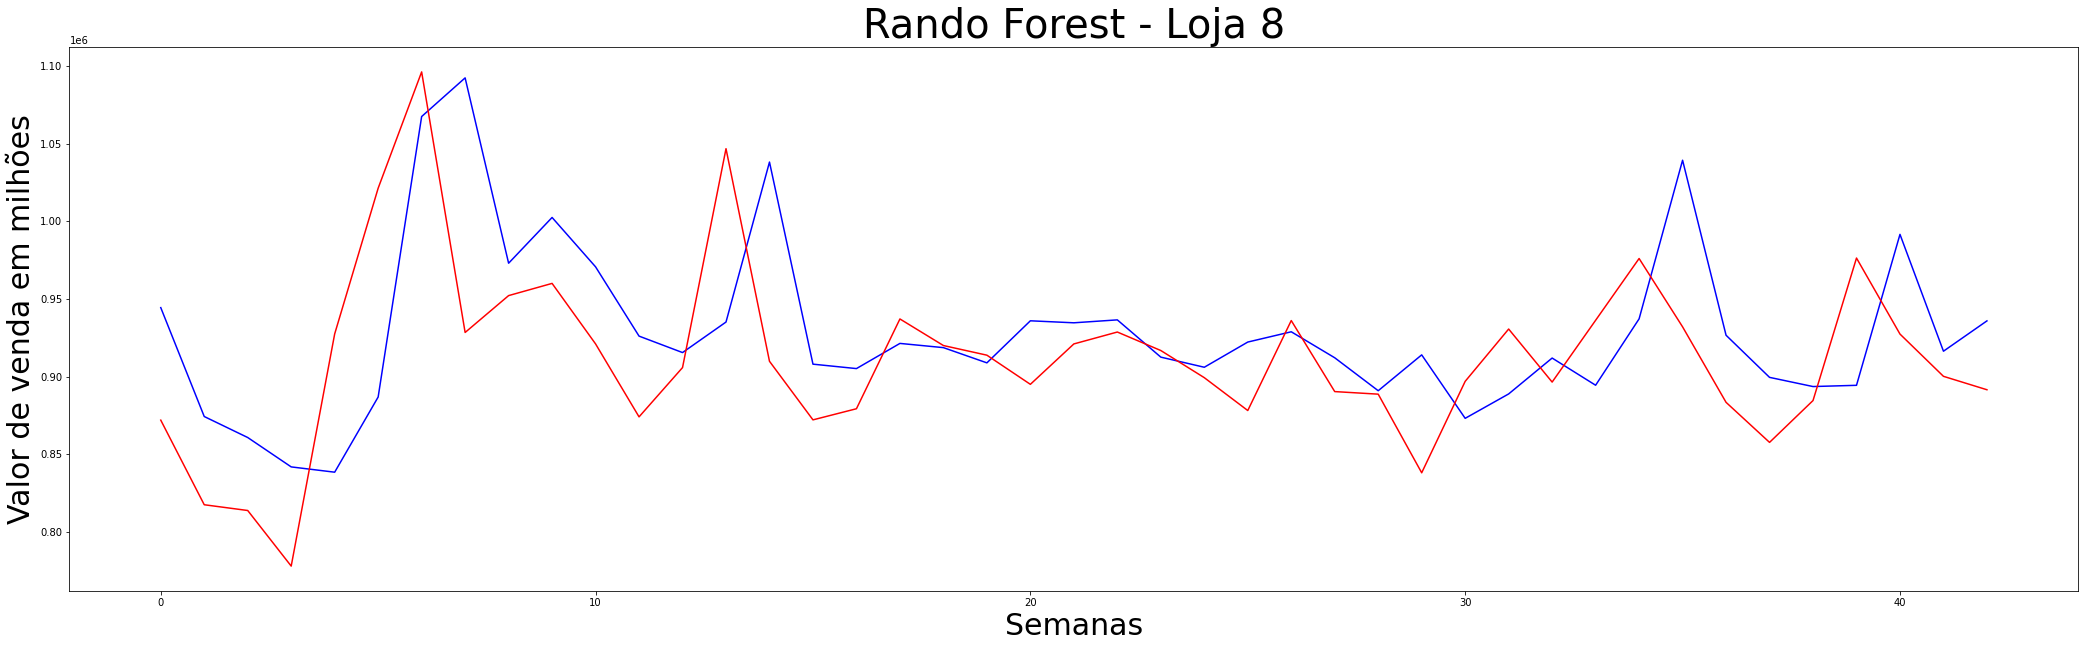

**************************************************
Resultados Loja 9:
0.06592625302426935 29616.79356345696 39396.5161155477


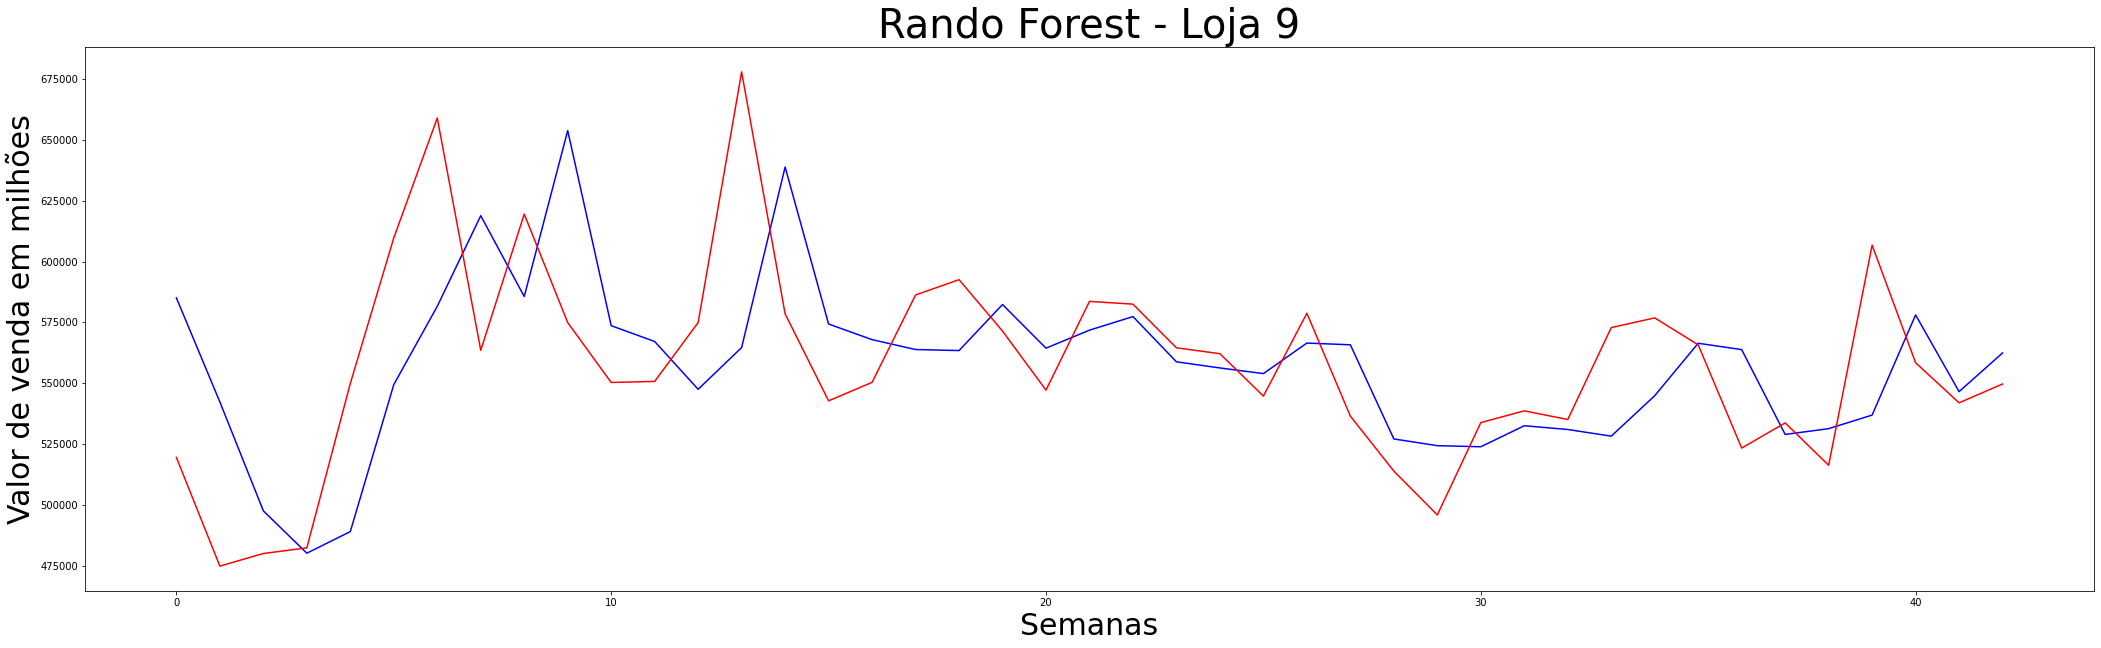

**************************************************
Resultados Loja 10:
0.03204940469692652 90556.9991529068 135116.97409134166


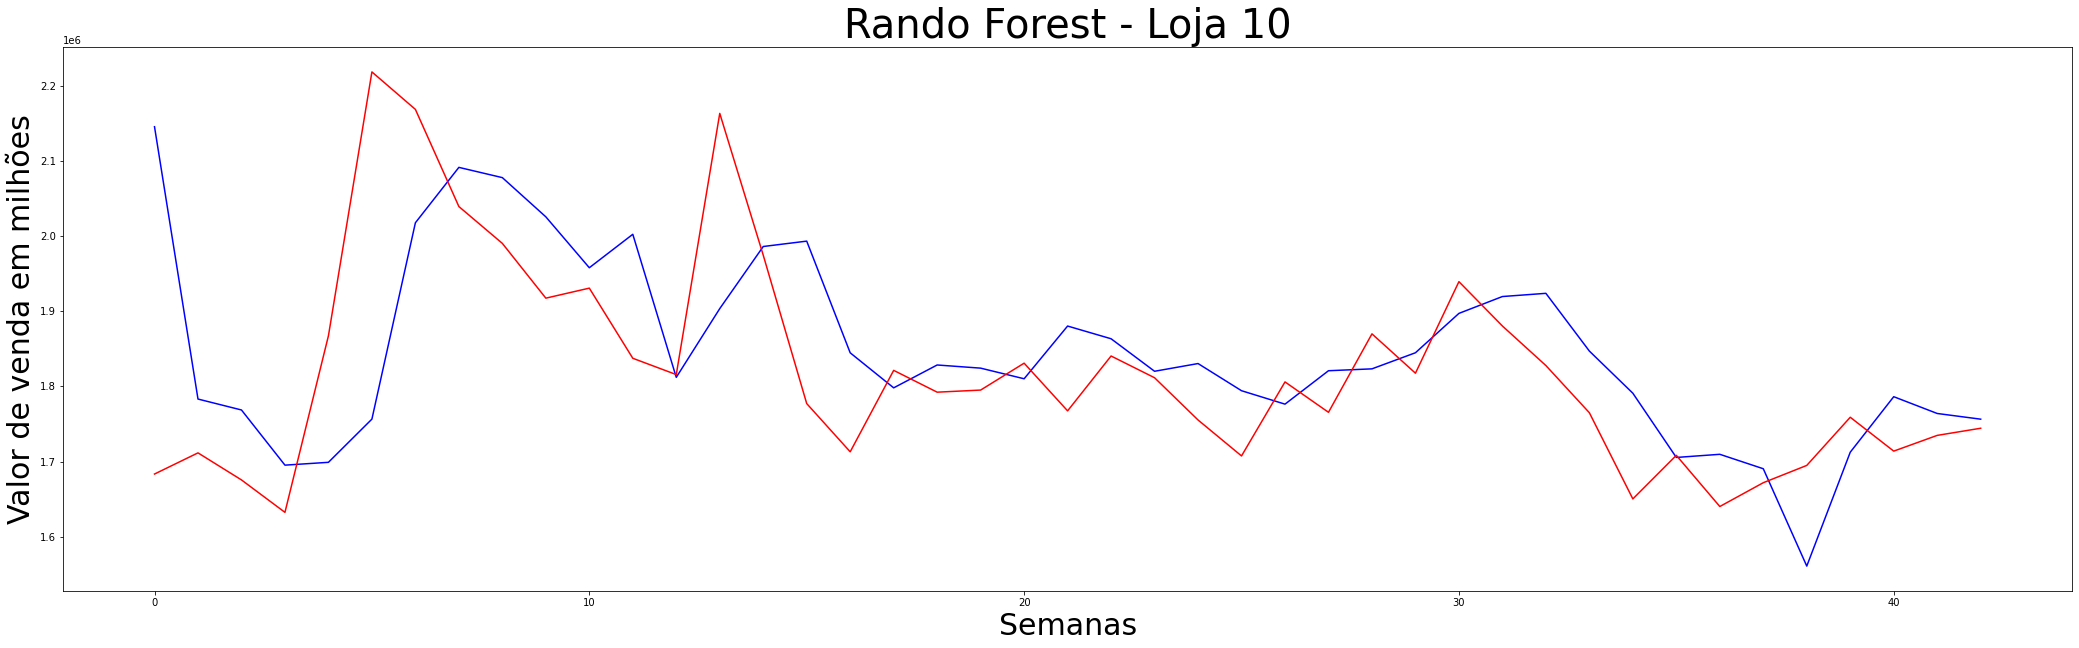

**************************************************
Resultados Loja 11:
-0.09503636611288835 76730.94102620445 100805.62009658253


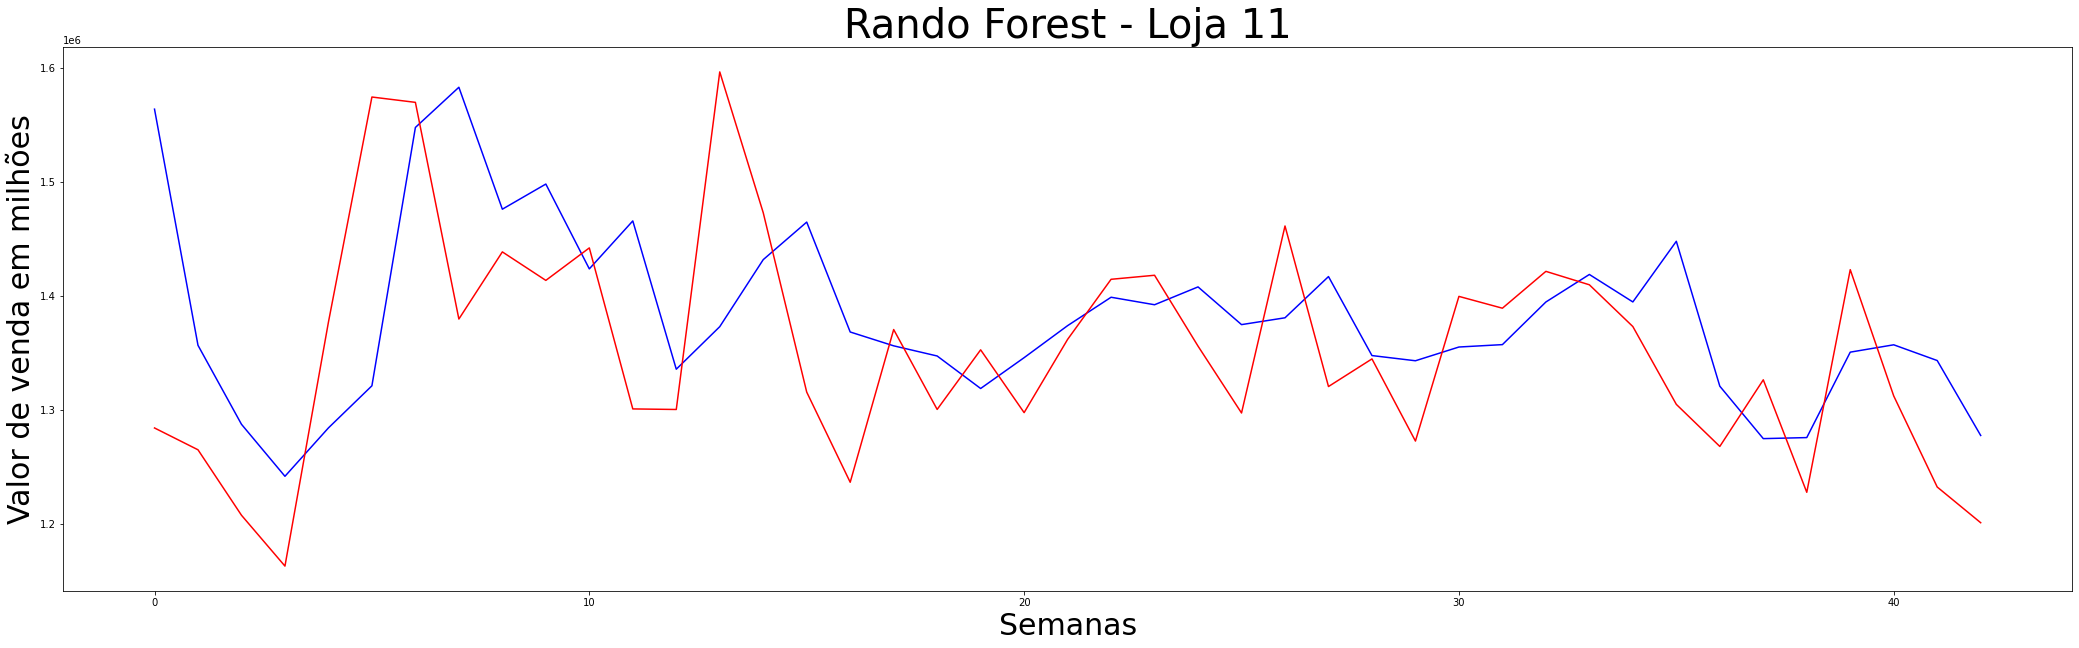

**************************************************
Resultados Loja 12:
-0.003936200866409889 62913.22133173255 85838.79734751051


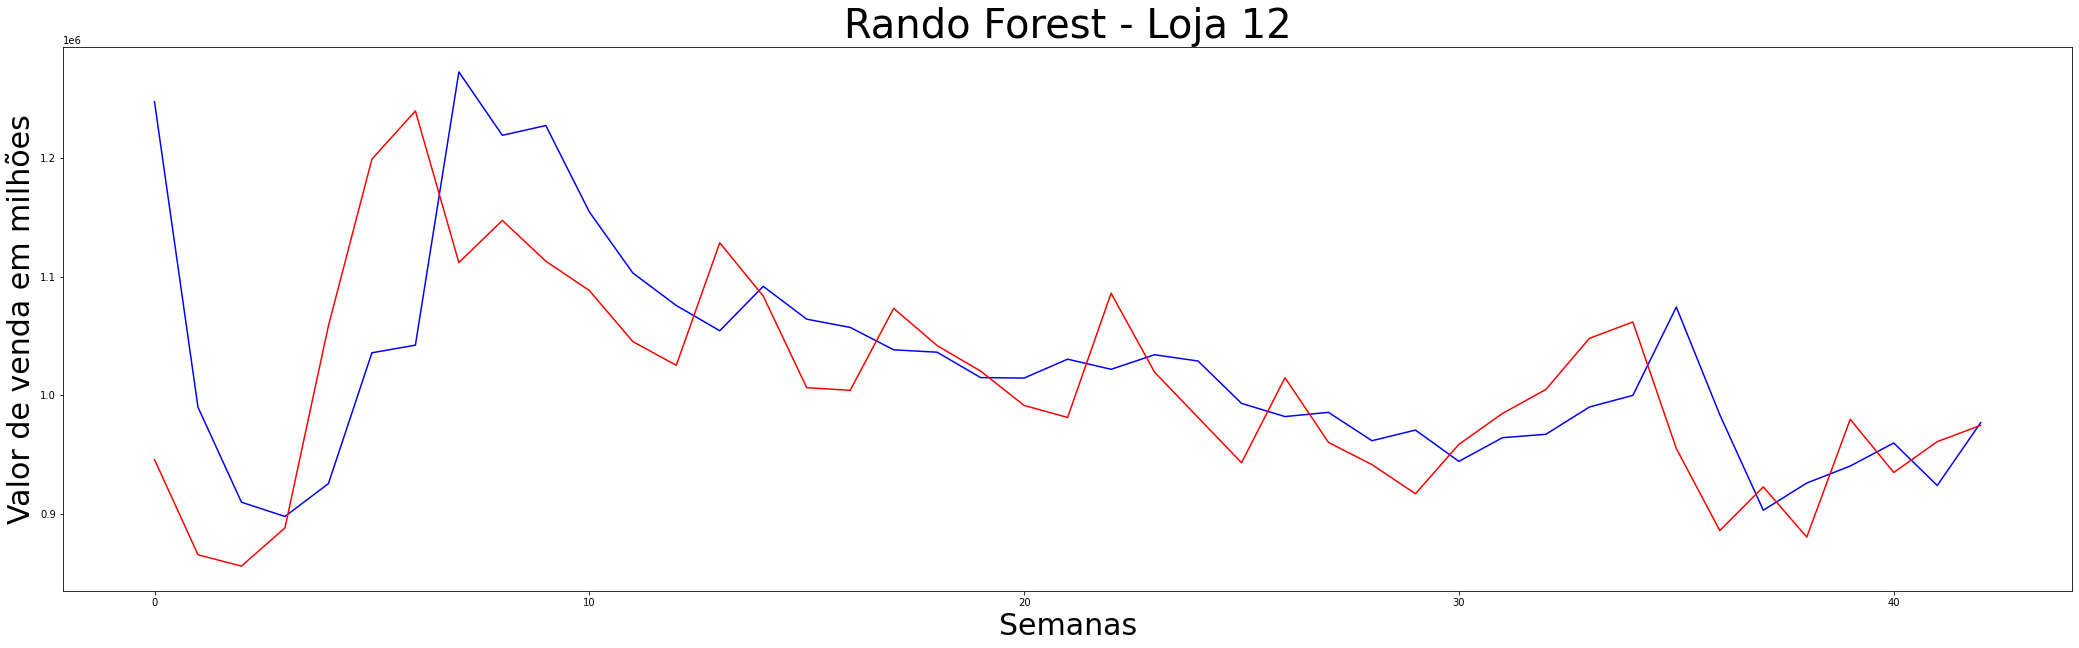

**************************************************
Resultados Loja 13:
-0.34995263976368474 93902.94987450639 127195.35917842745


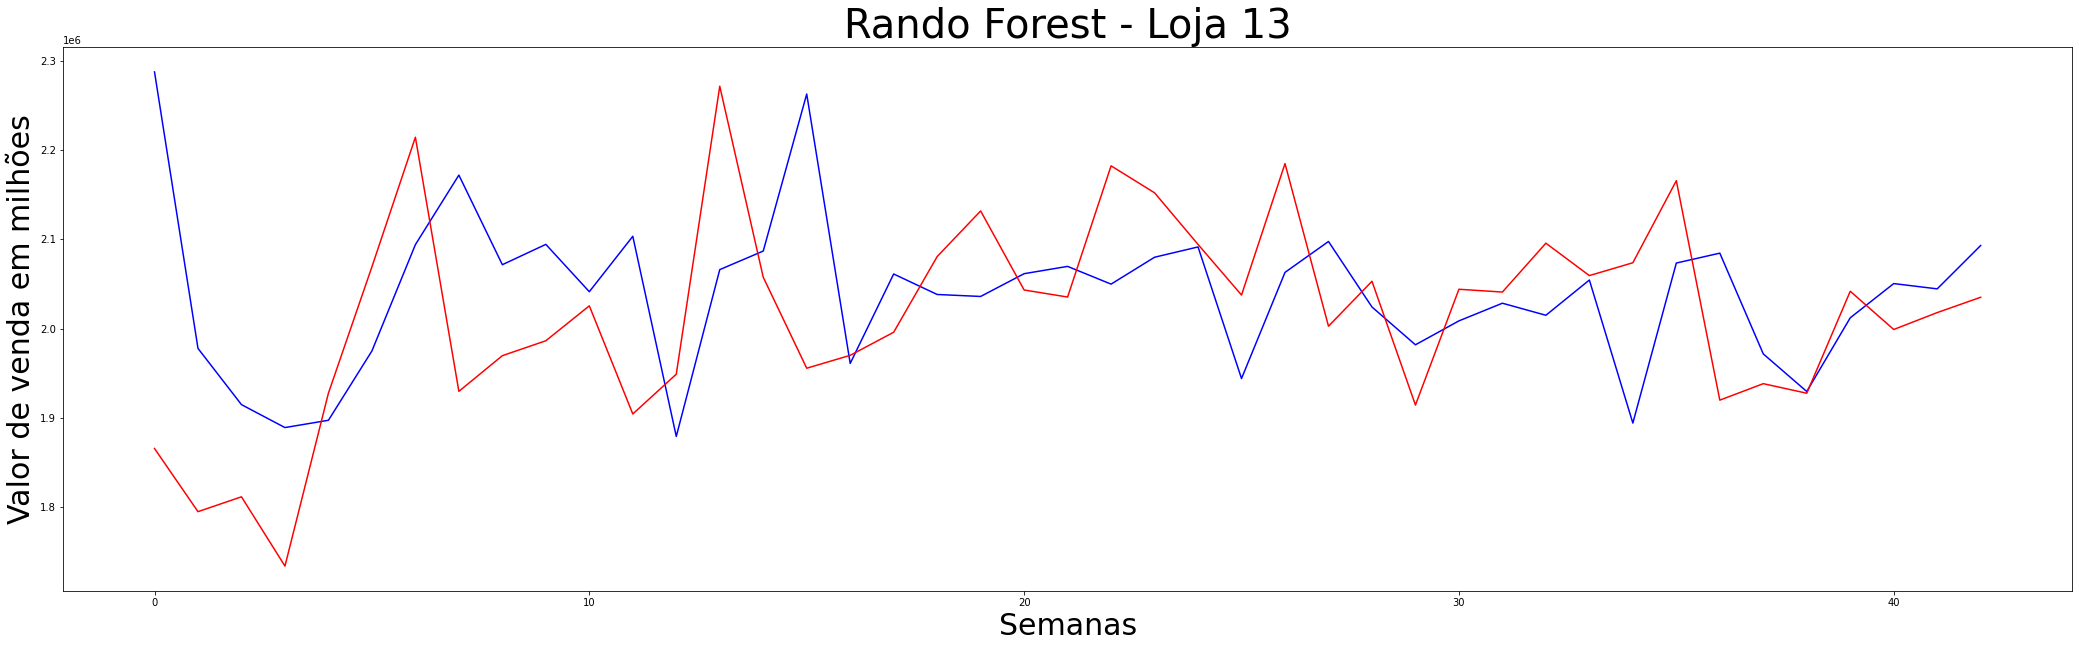

**************************************************
Resultados Loja 14:
0.27844941796478595 129600.14479358729 166867.2299517278


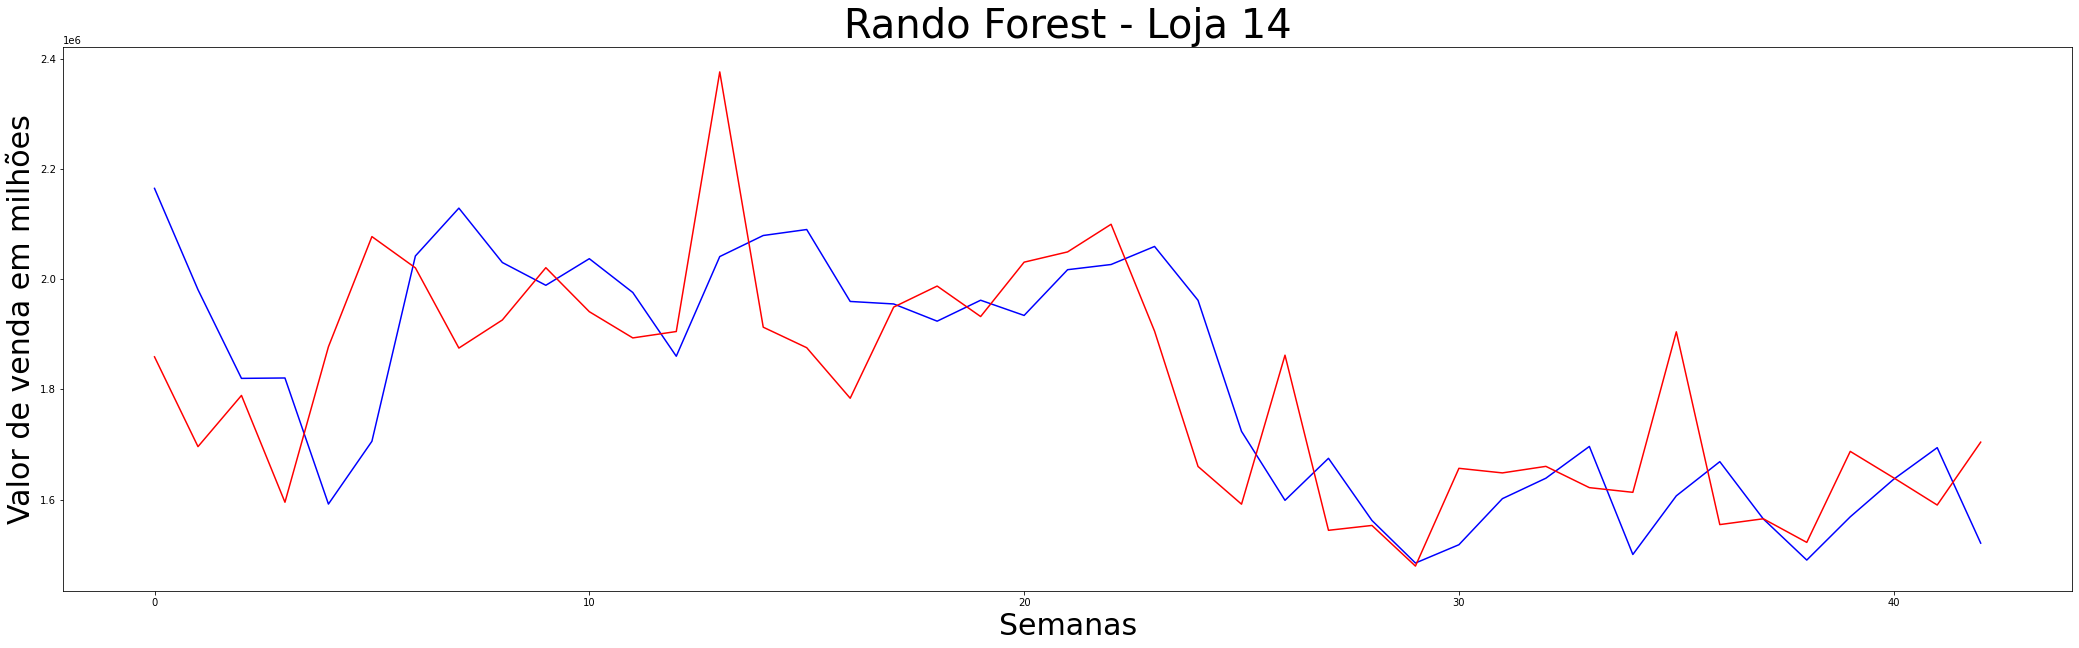

**************************************************
Resultados Loja 15:
0.021531271956141462 35979.3075217308 52030.34968135903


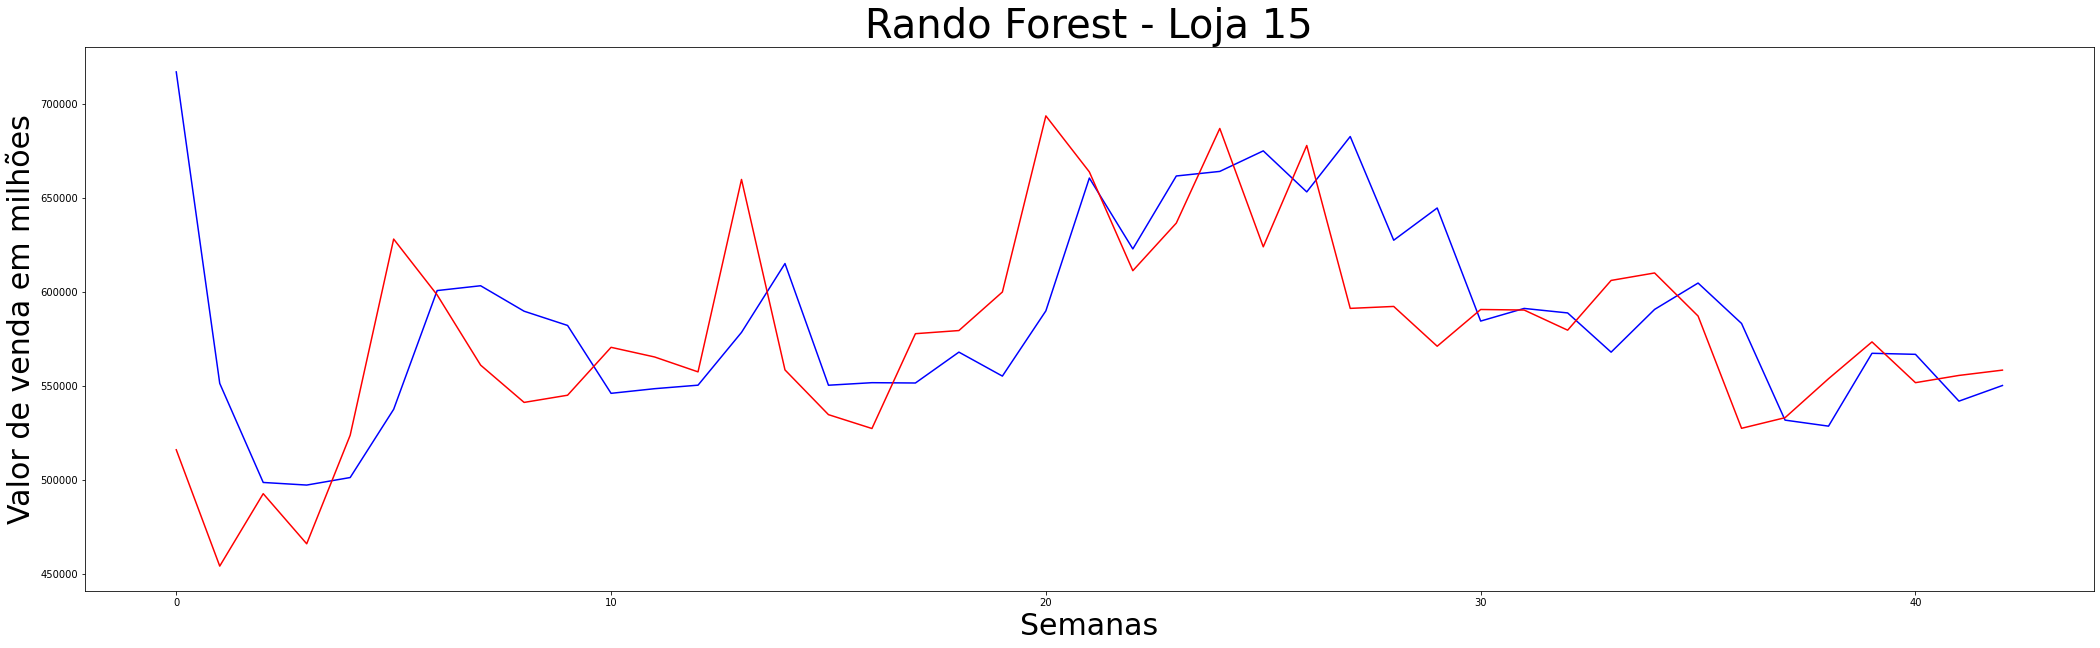

**************************************************
Resultados Loja 16:
0.28852517199192373 33433.87975739435 42677.334121583954


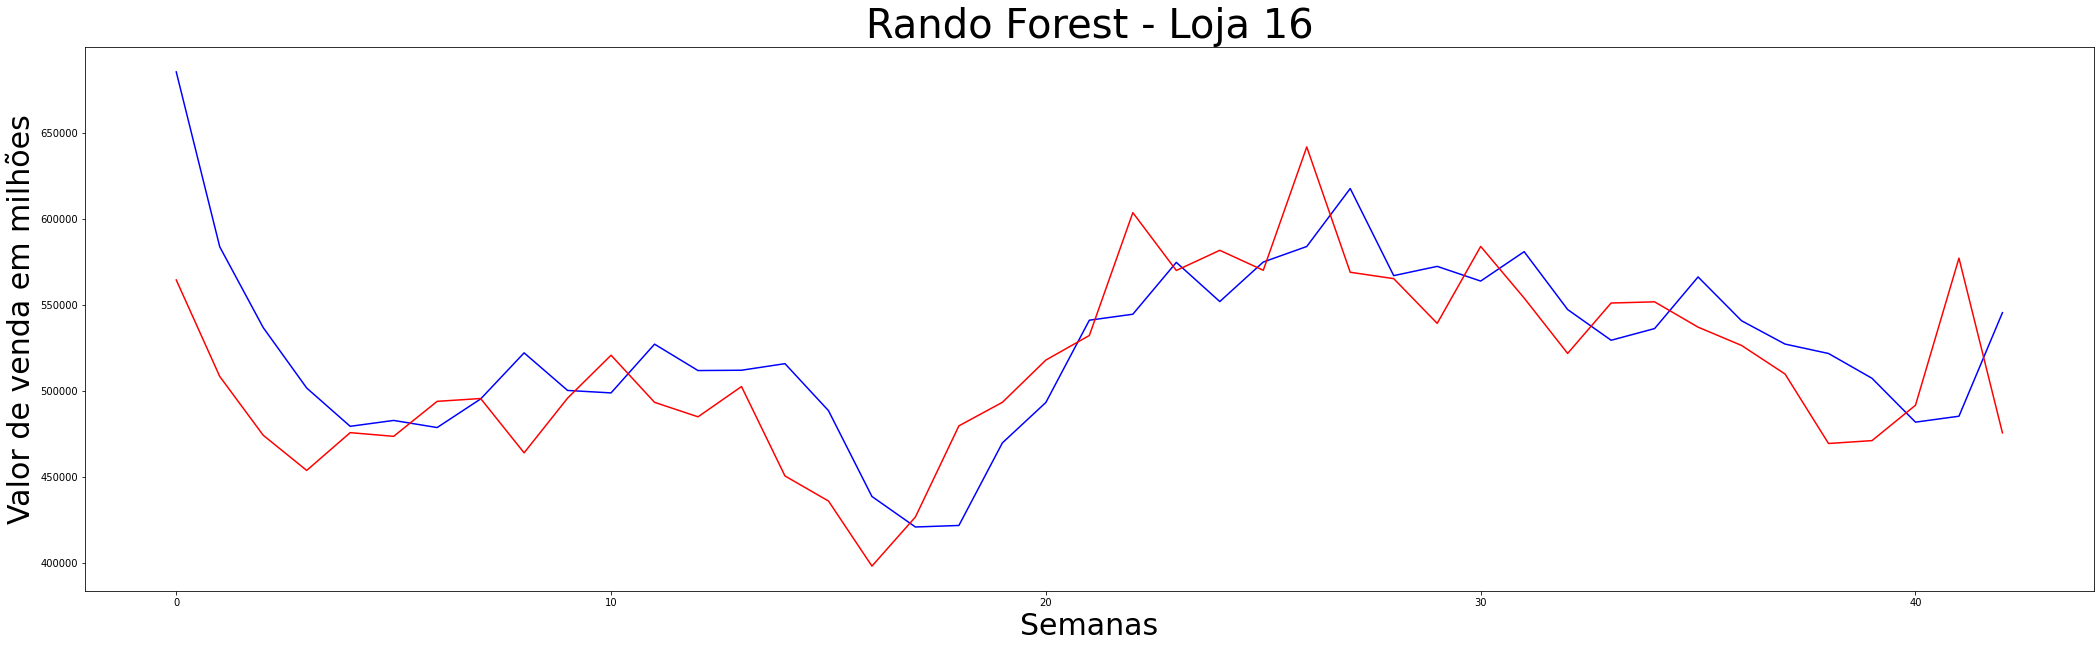

**************************************************
Resultados Loja 17:
-0.05900837974330653 66208.95160483659 96144.67681277233


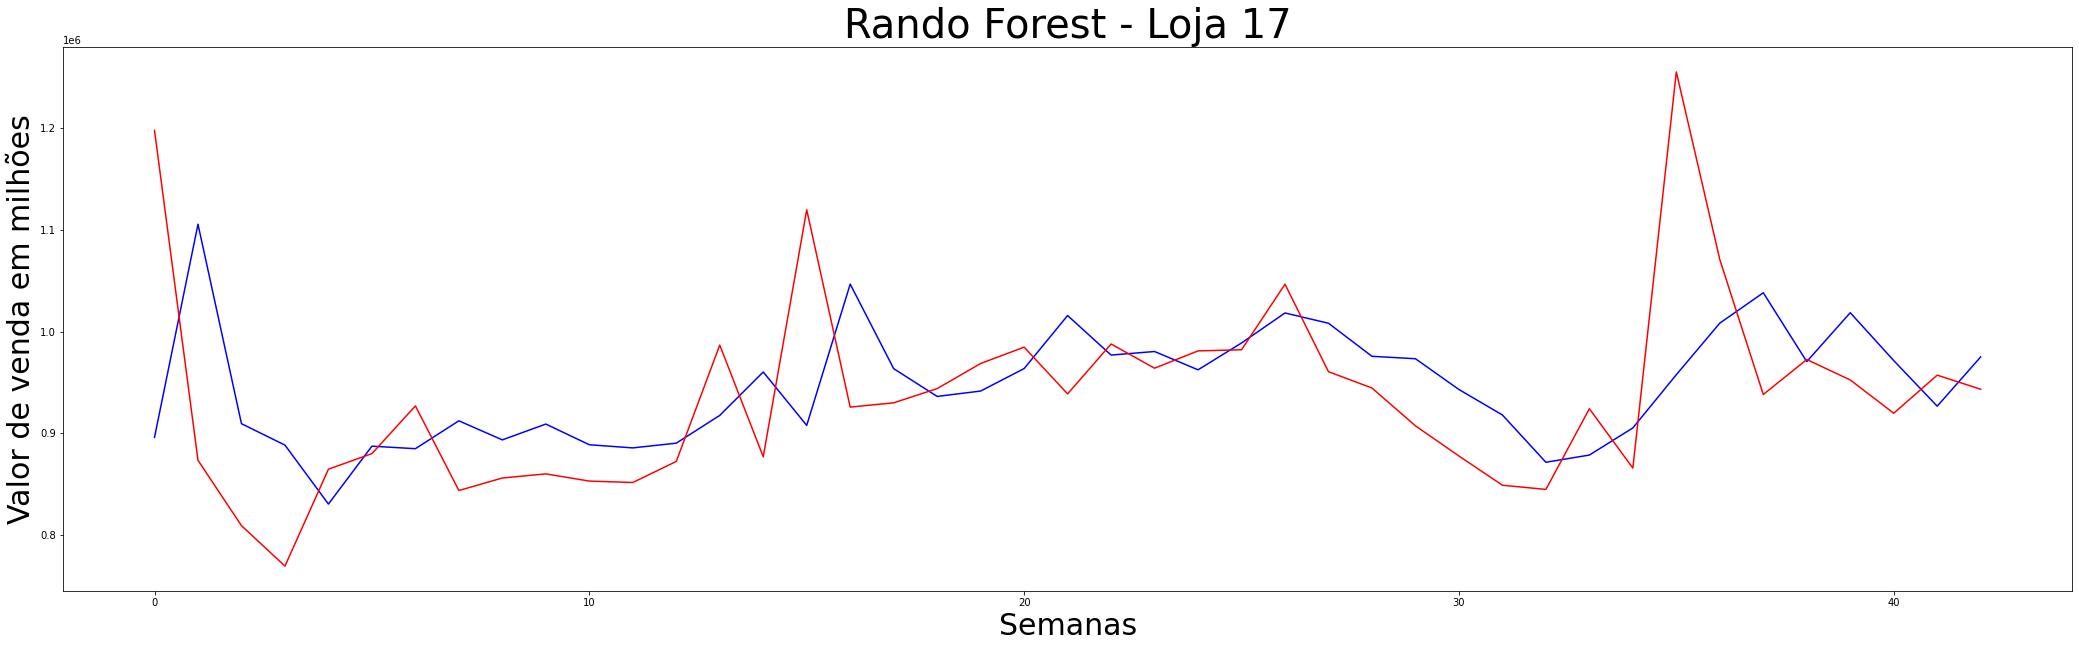

**************************************************
Resultados Loja 18:
-0.5272484206531176 72782.83188713982 91438.9784459061


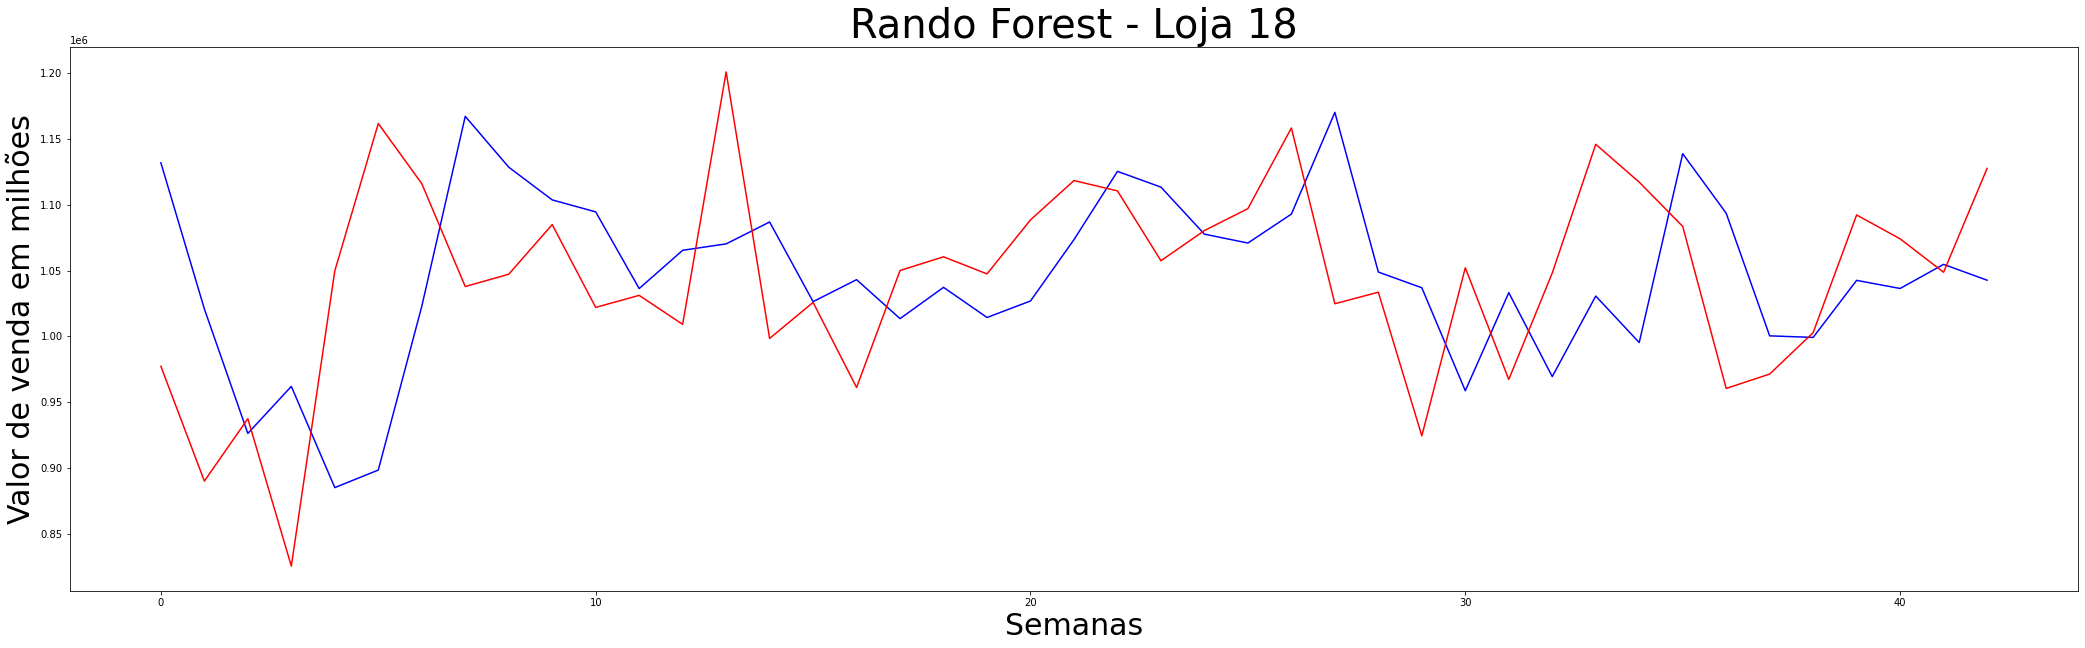

**************************************************
Resultados Loja 19:
-0.2537362180073488 79817.15470072902 104196.0591914189


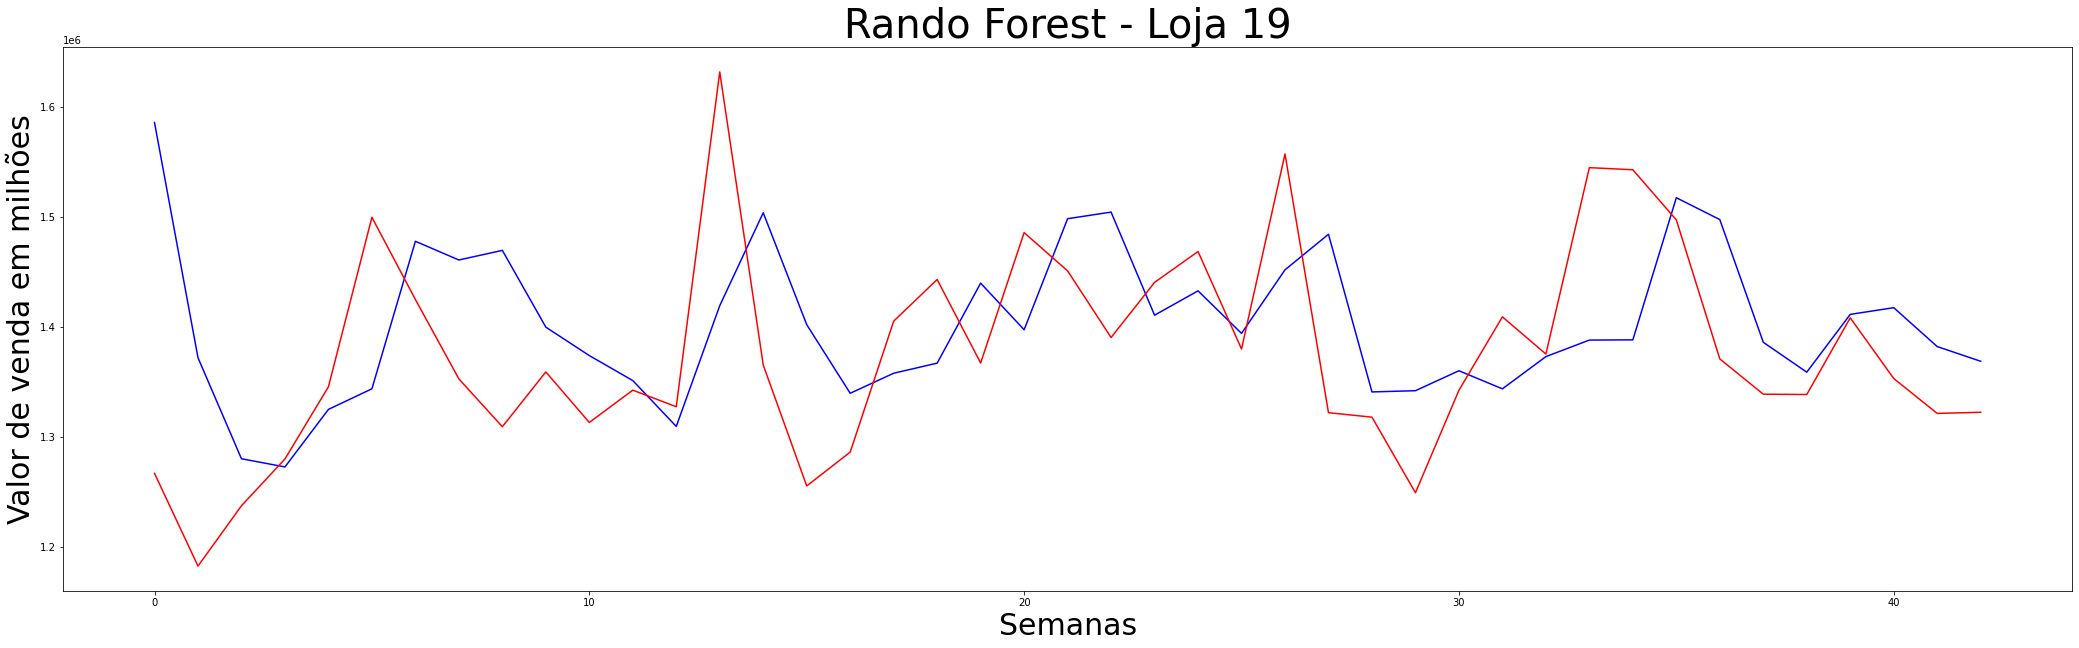

**************************************************
Resultados Loja 20:
-0.5637617353178916 141850.8746989507 186494.3762643627


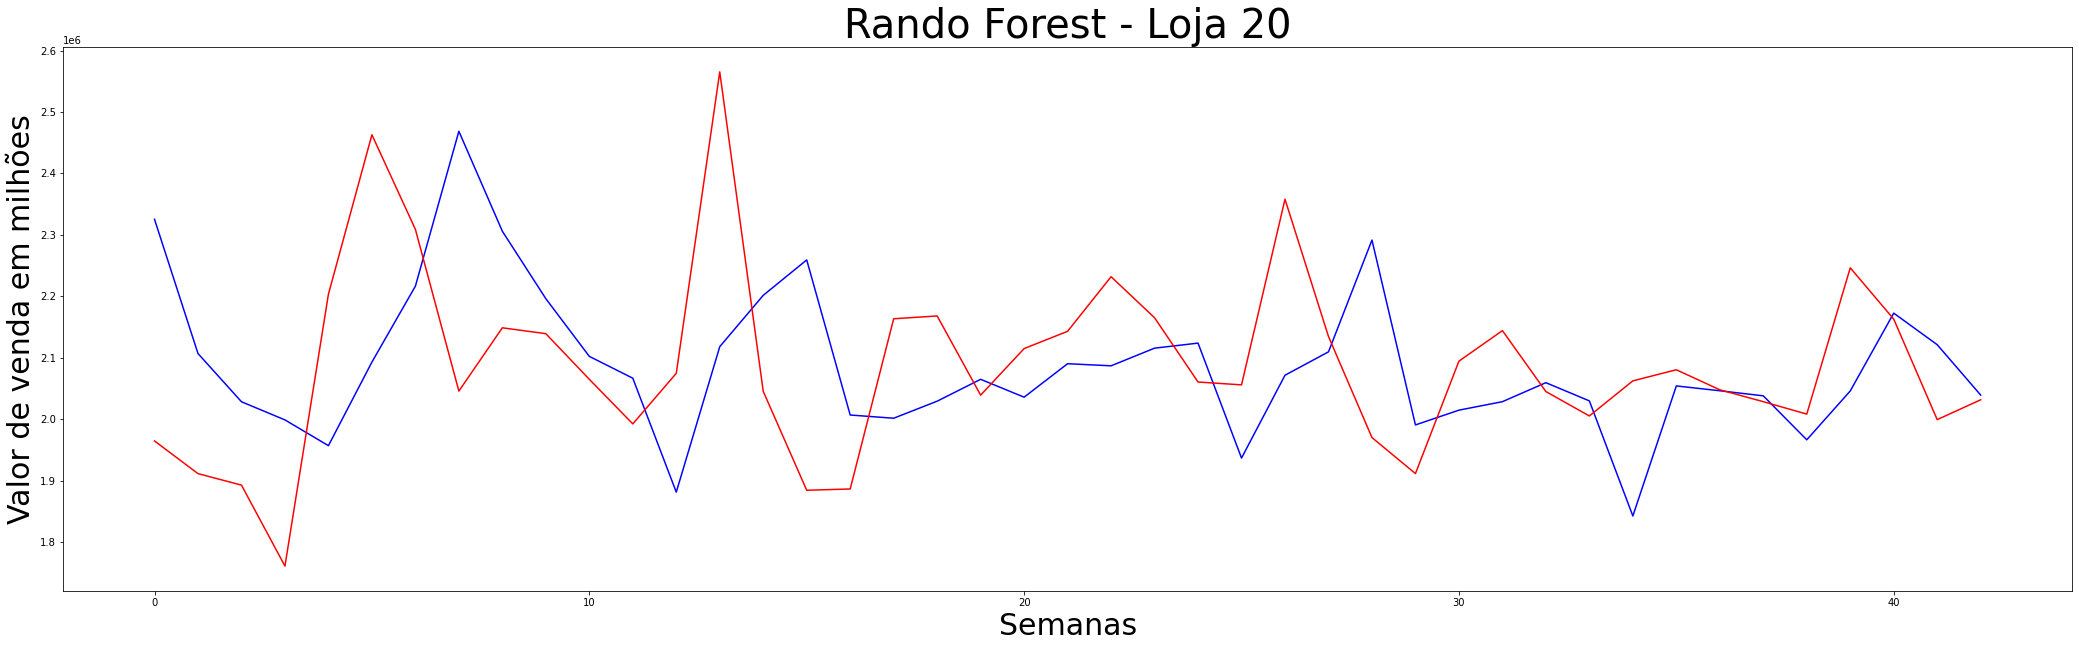

**************************************************
Resultados Loja 21:
-0.5193542370315178 42645.56423620899 63066.058914035595


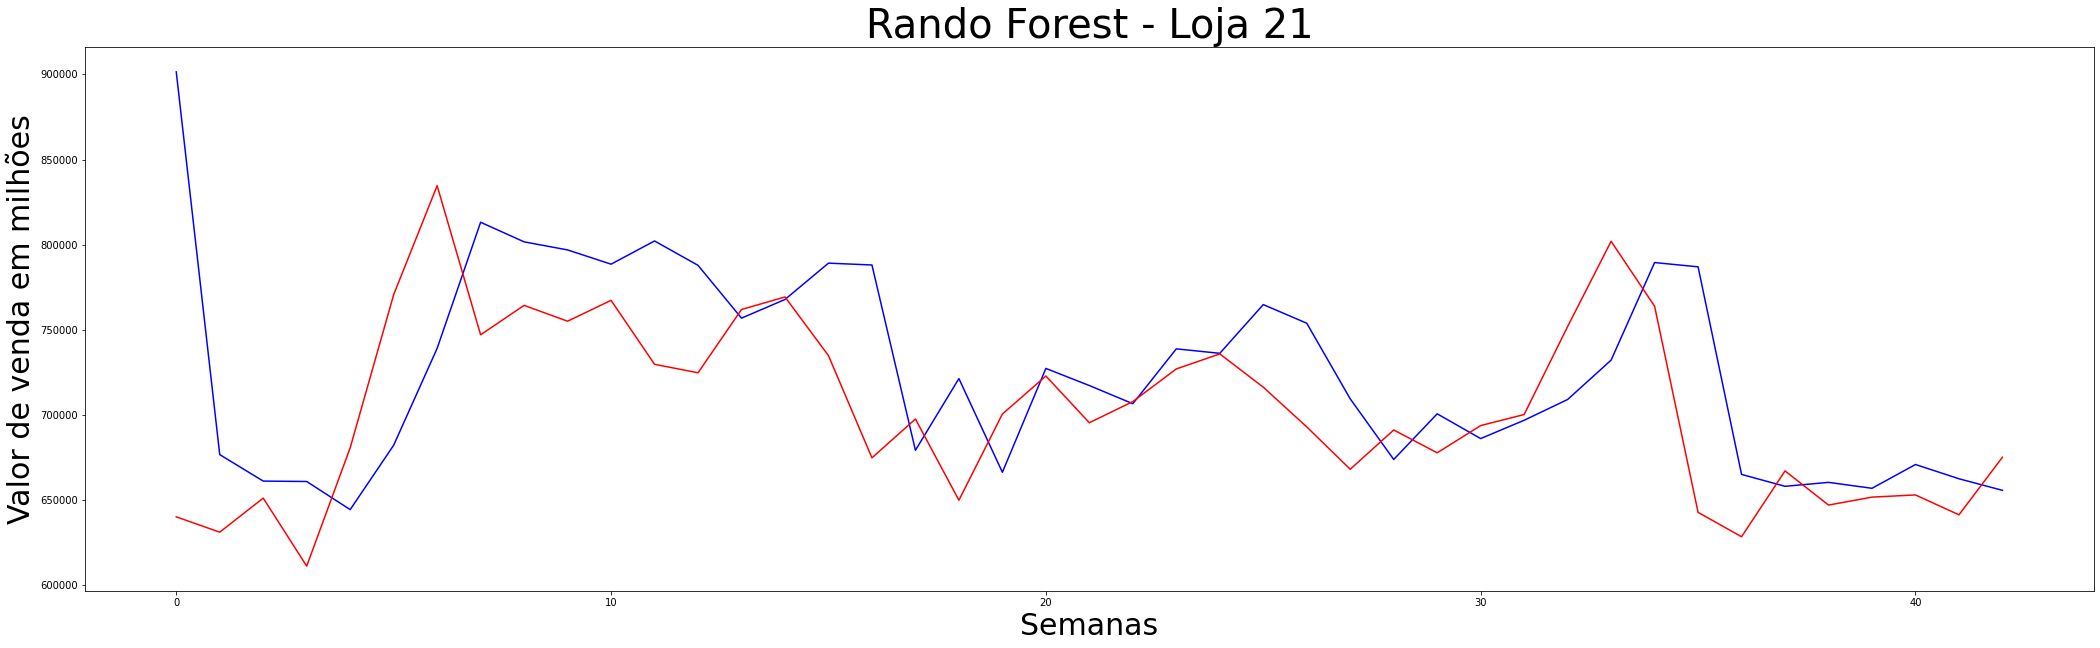

**************************************************
Resultados Loja 22:
-0.16250237257043 60471.805205633245 78477.13376641668


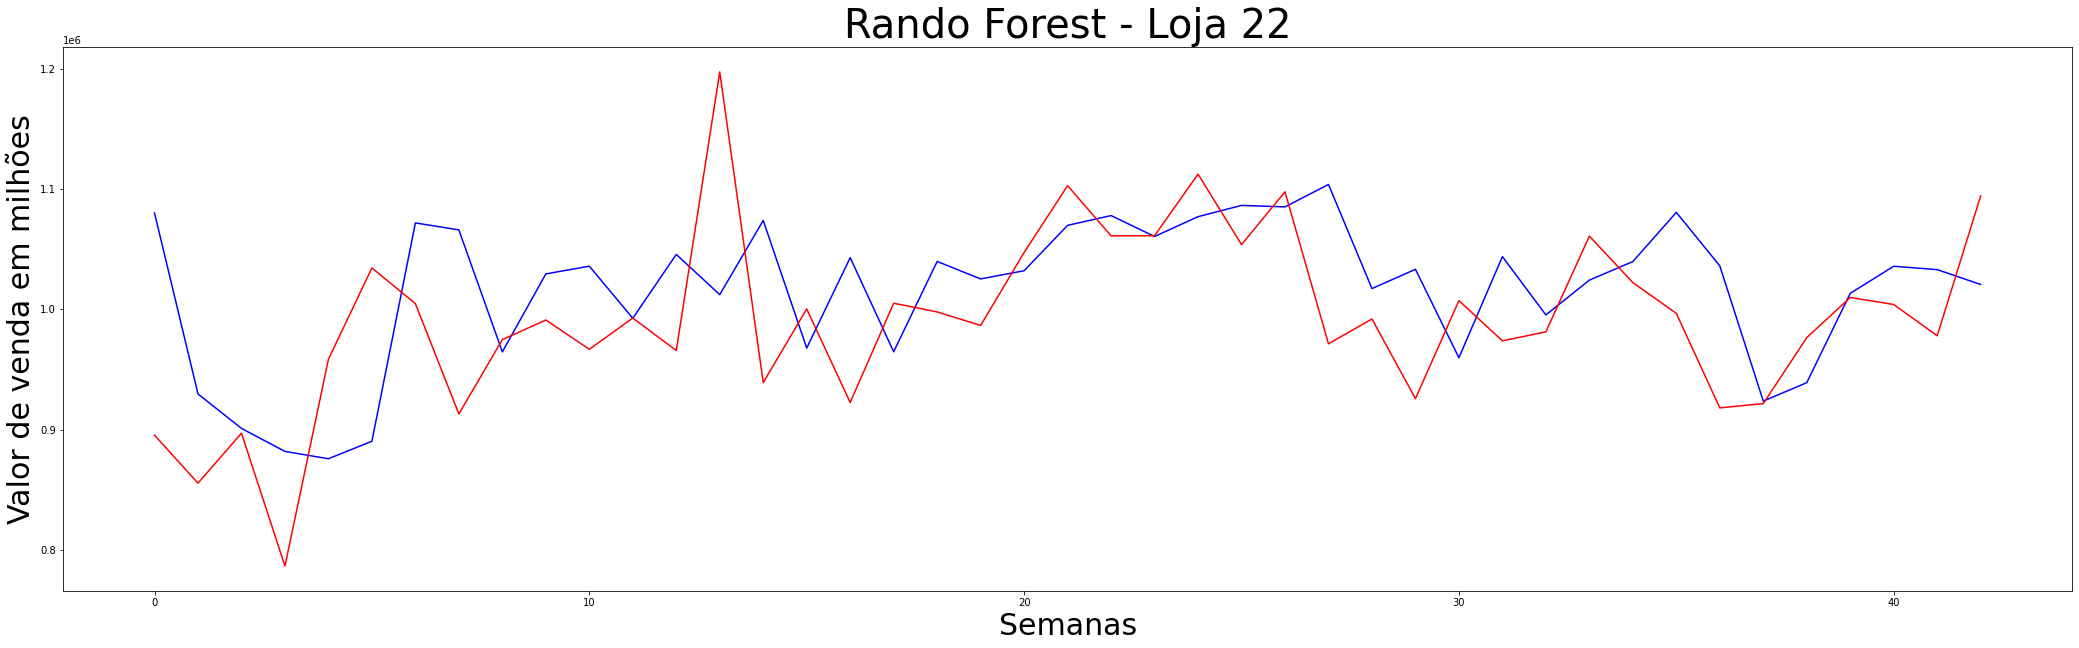

**************************************************
Resultados Loja 23:
0.24272772971711765 87346.38703852768 123214.8729985318


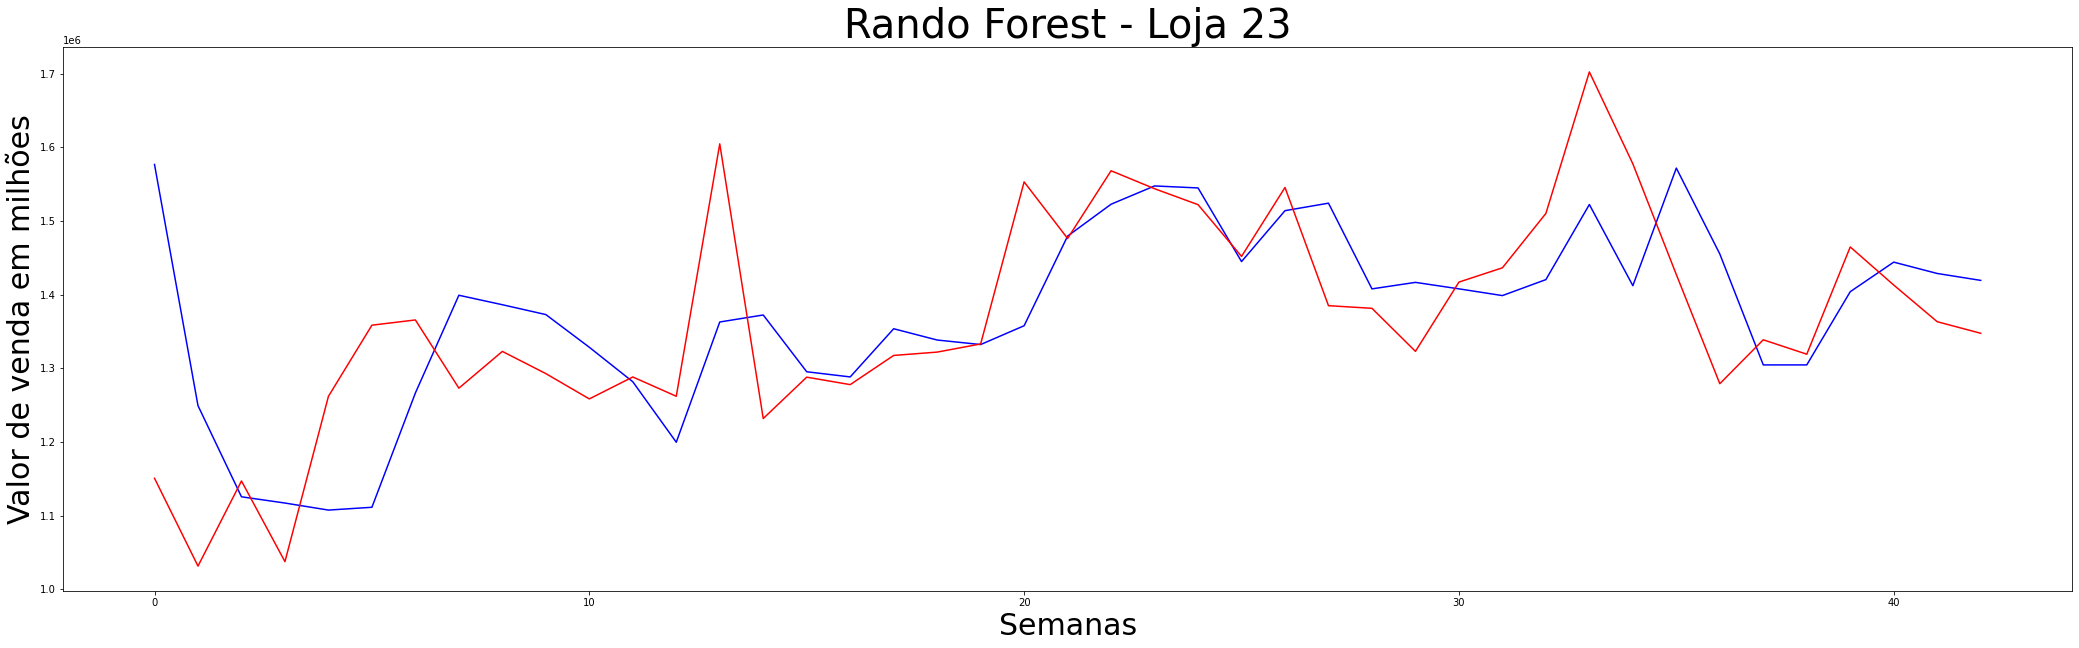

**************************************************
Resultados Loja 24:
-0.03822911494391623 91235.3013140796 114378.31665024538


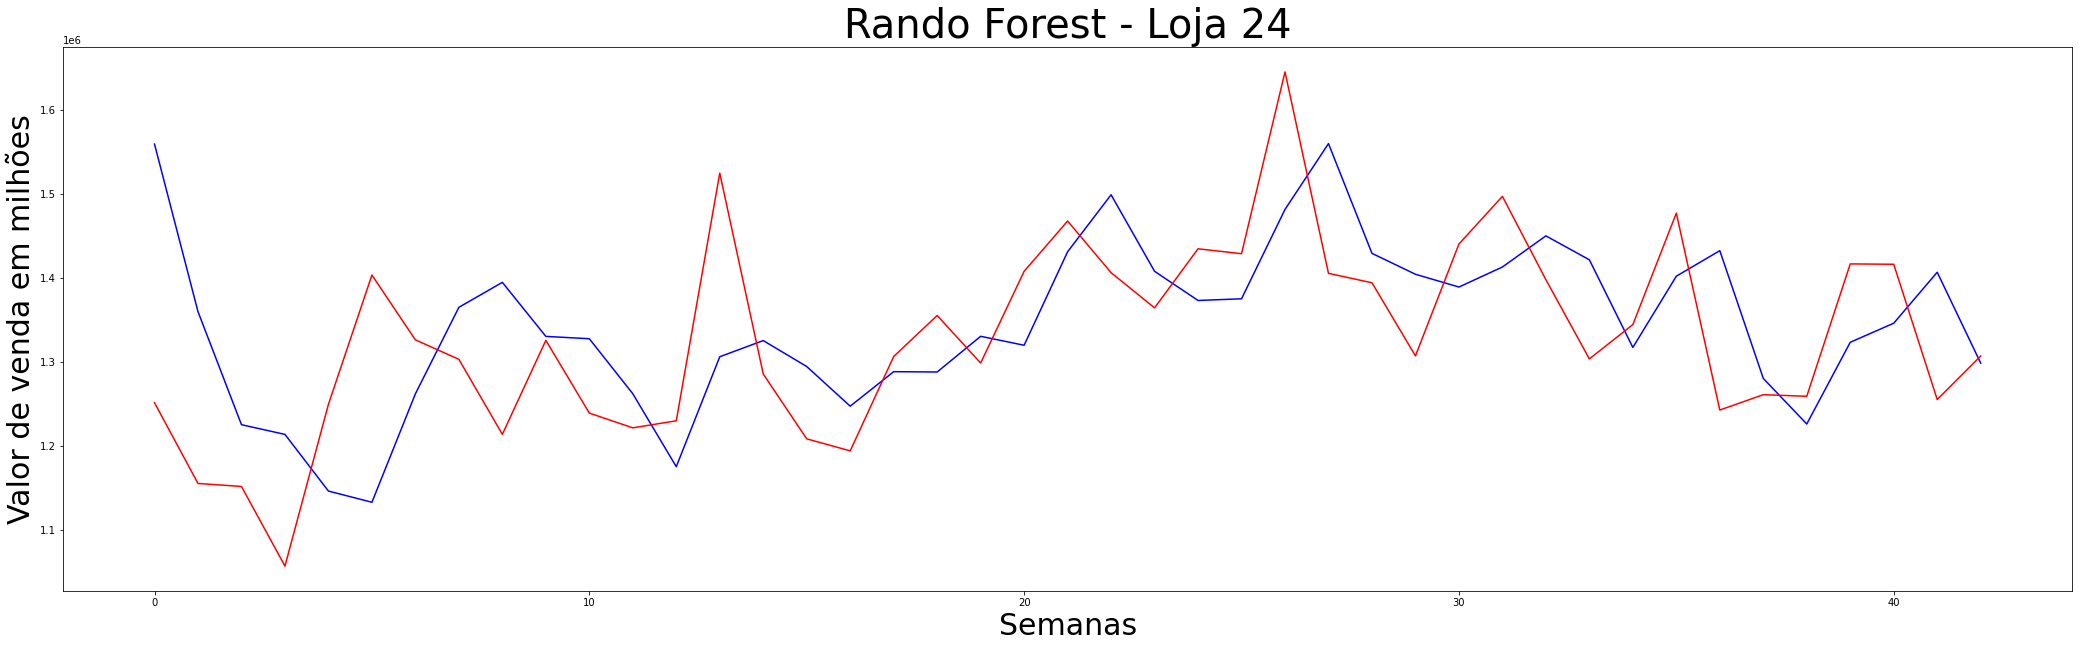

**************************************************
Resultados Loja 25:
-0.03744923507412823 35726.60329586356 47268.88804454093


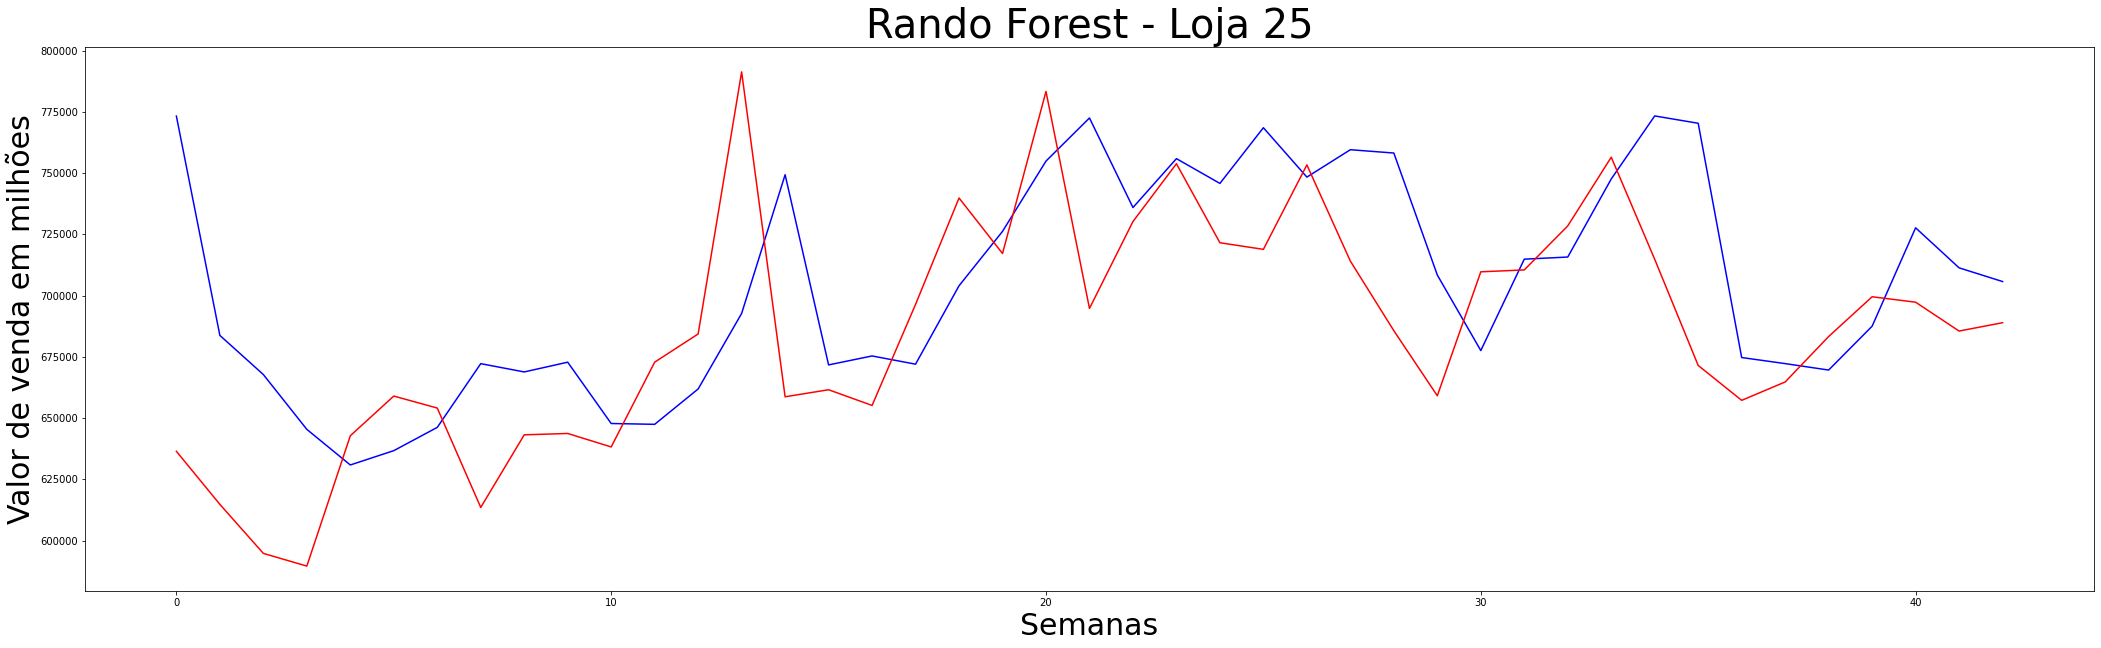

**************************************************
Resultados Loja 26:
0.12553327175073425 61207.62790118578 77937.28550664034


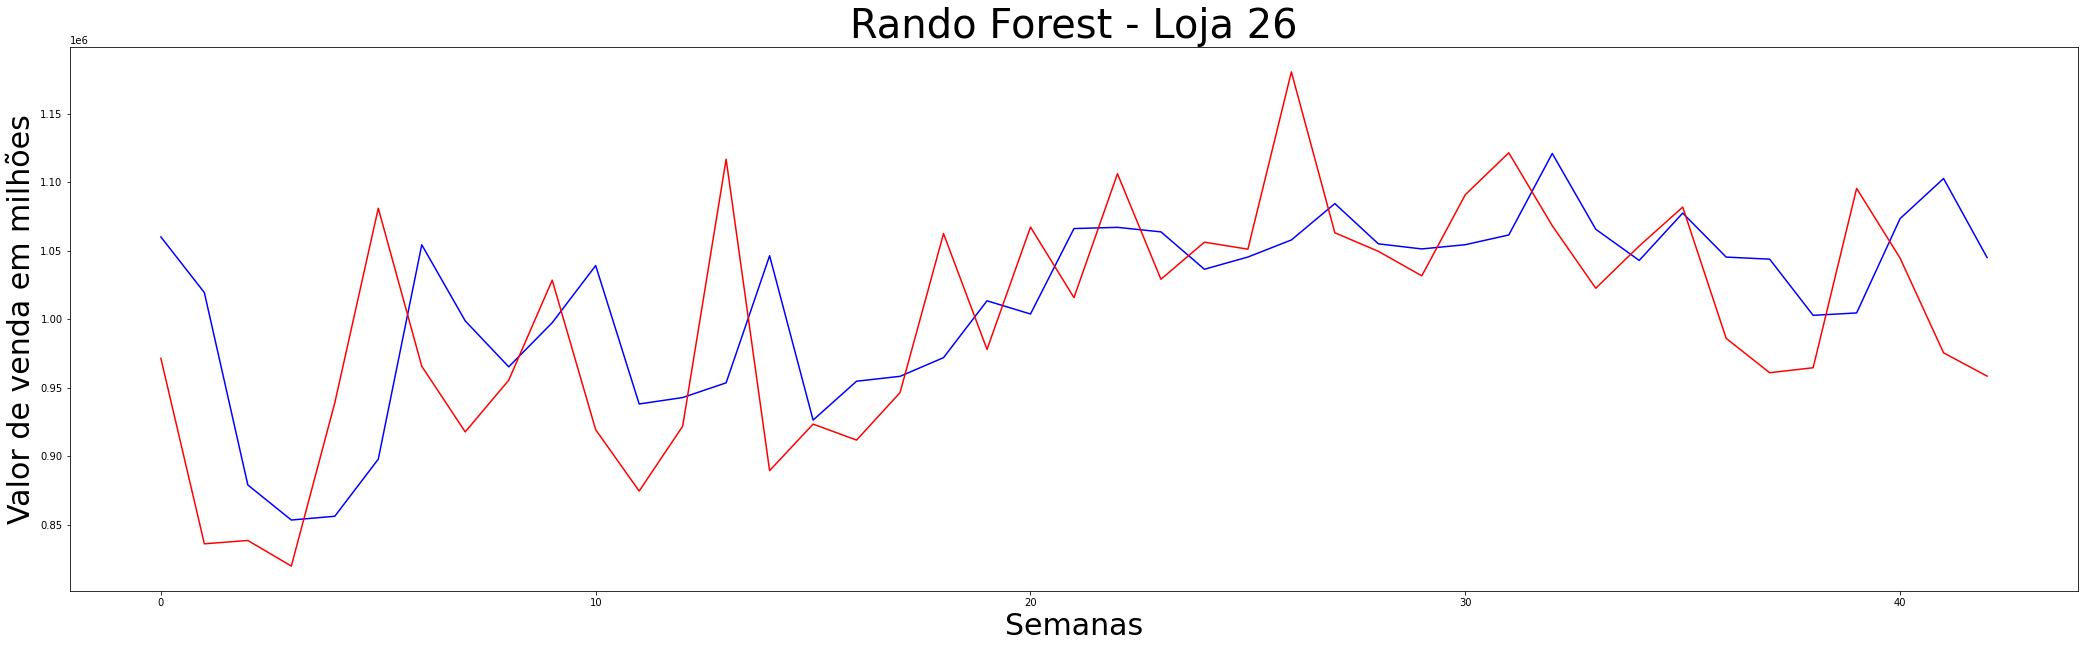

**************************************************
Resultados Loja 27:
0.1966881120185986 90213.9990698943 121052.00828962788


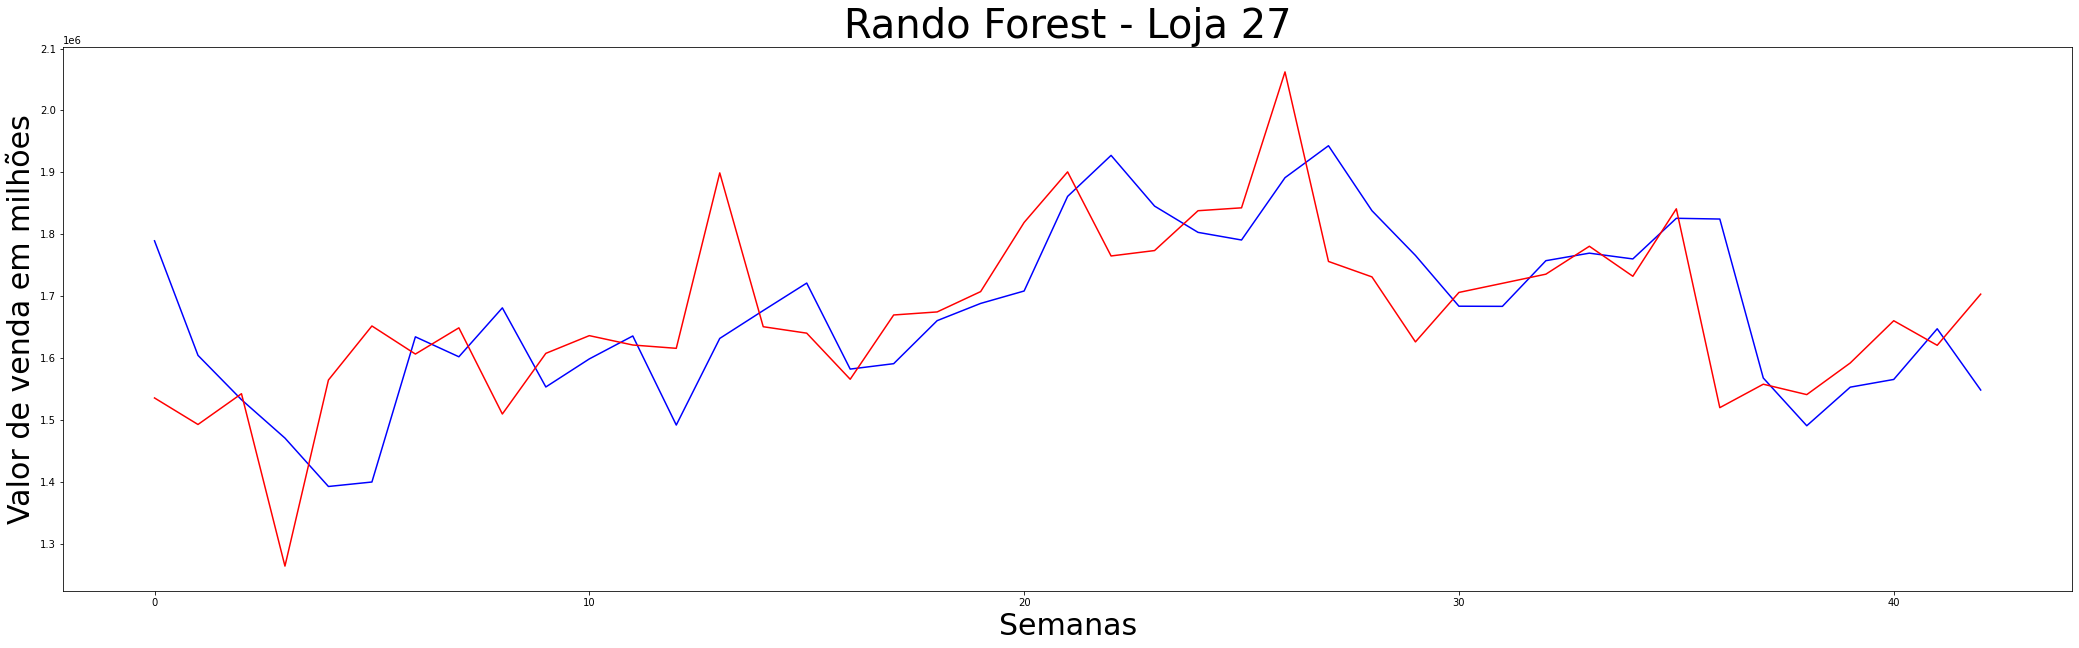

**************************************************
Resultados Loja 28:
0.1183062370365291 117398.24724016135 142963.3390255314


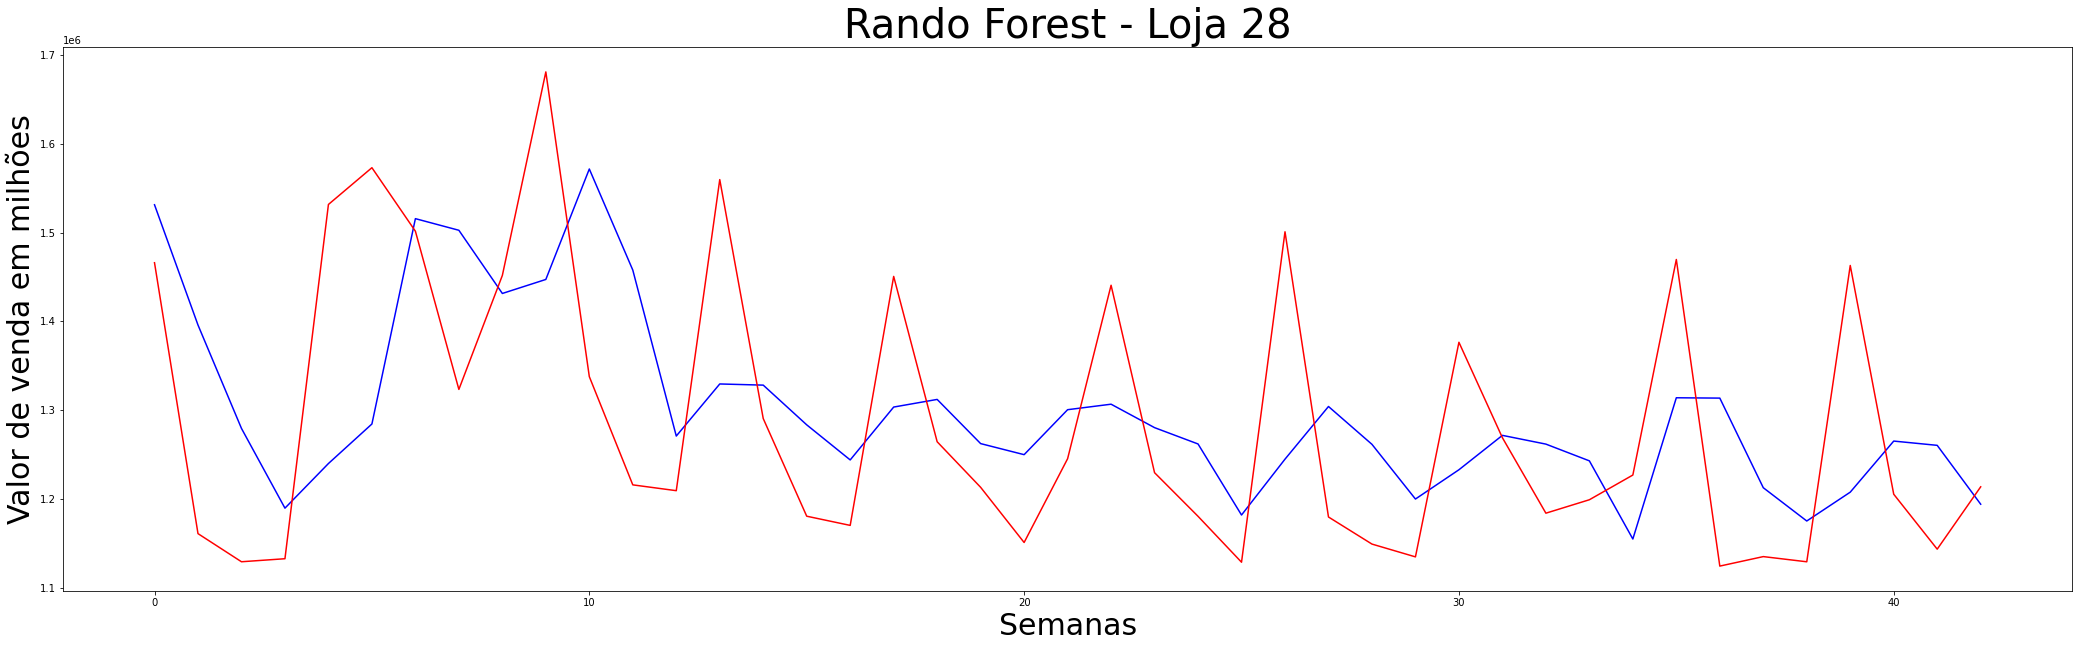

**************************************************
Resultados Loja 29:
-0.3245382529826062 36718.69314772834 52919.44553653313


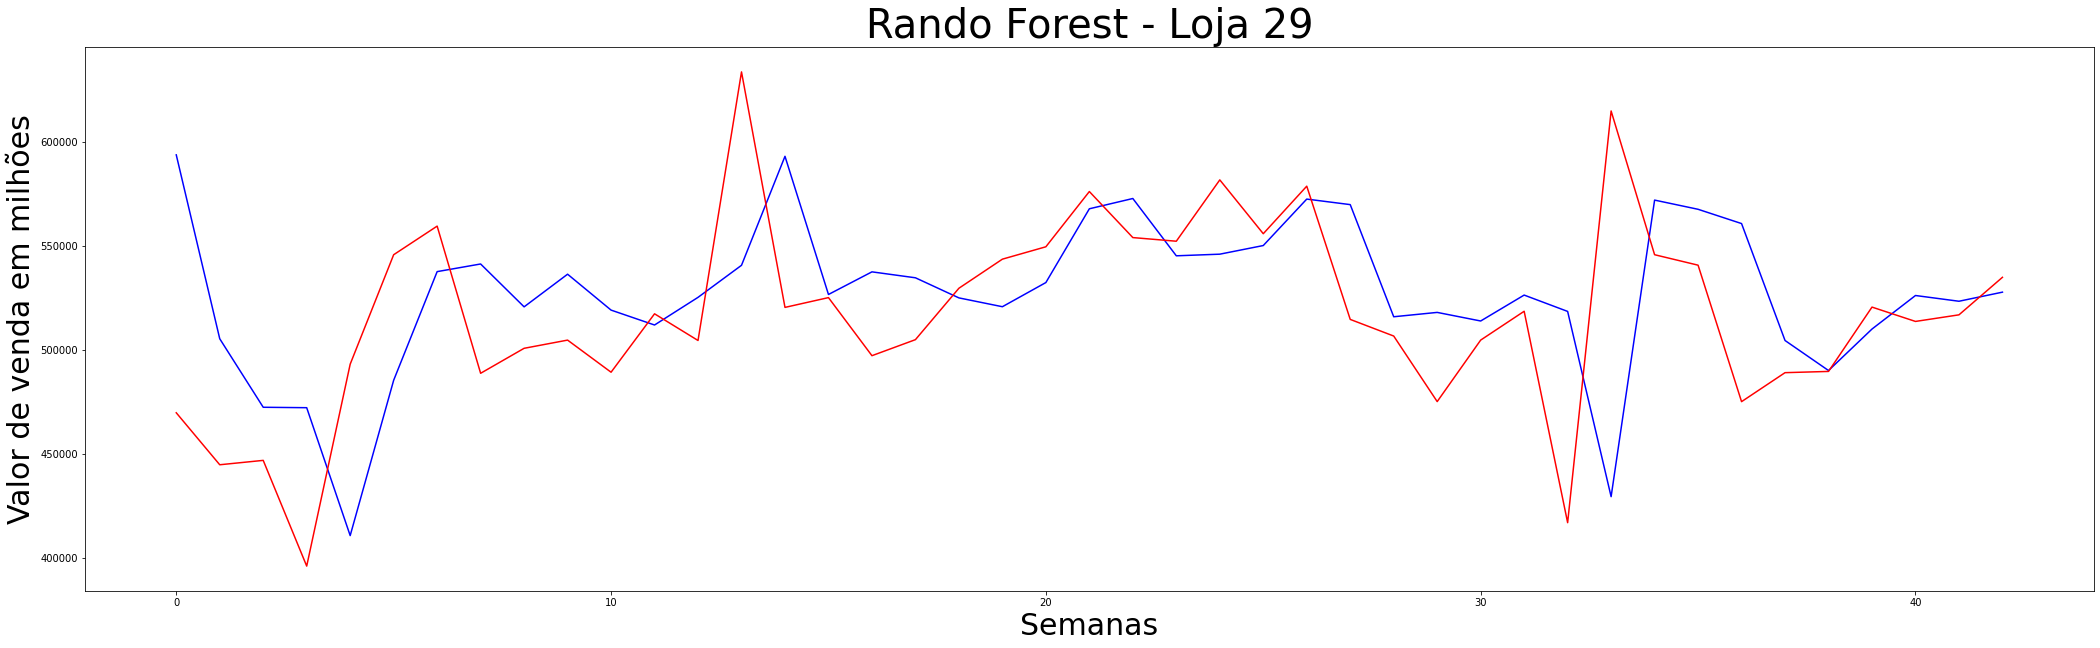

**************************************************
Resultados Loja 30:
-0.7931994918275571 12287.874466415122 15698.99855933333


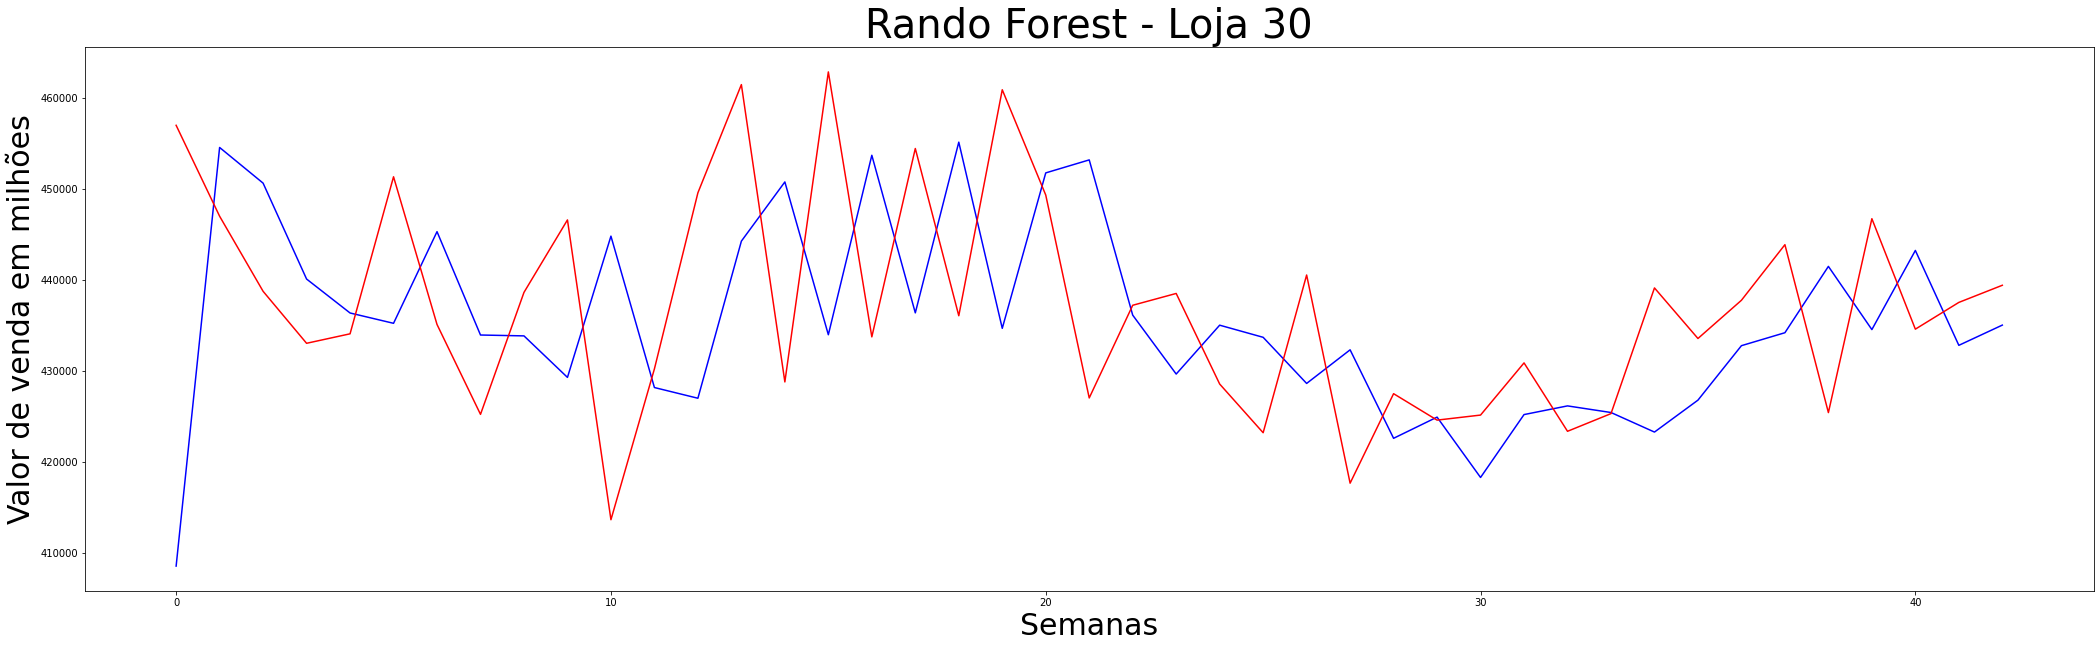

**************************************************
Resultados Loja 31:
-0.5060031355409942 53541.45669693602 71993.79154689694


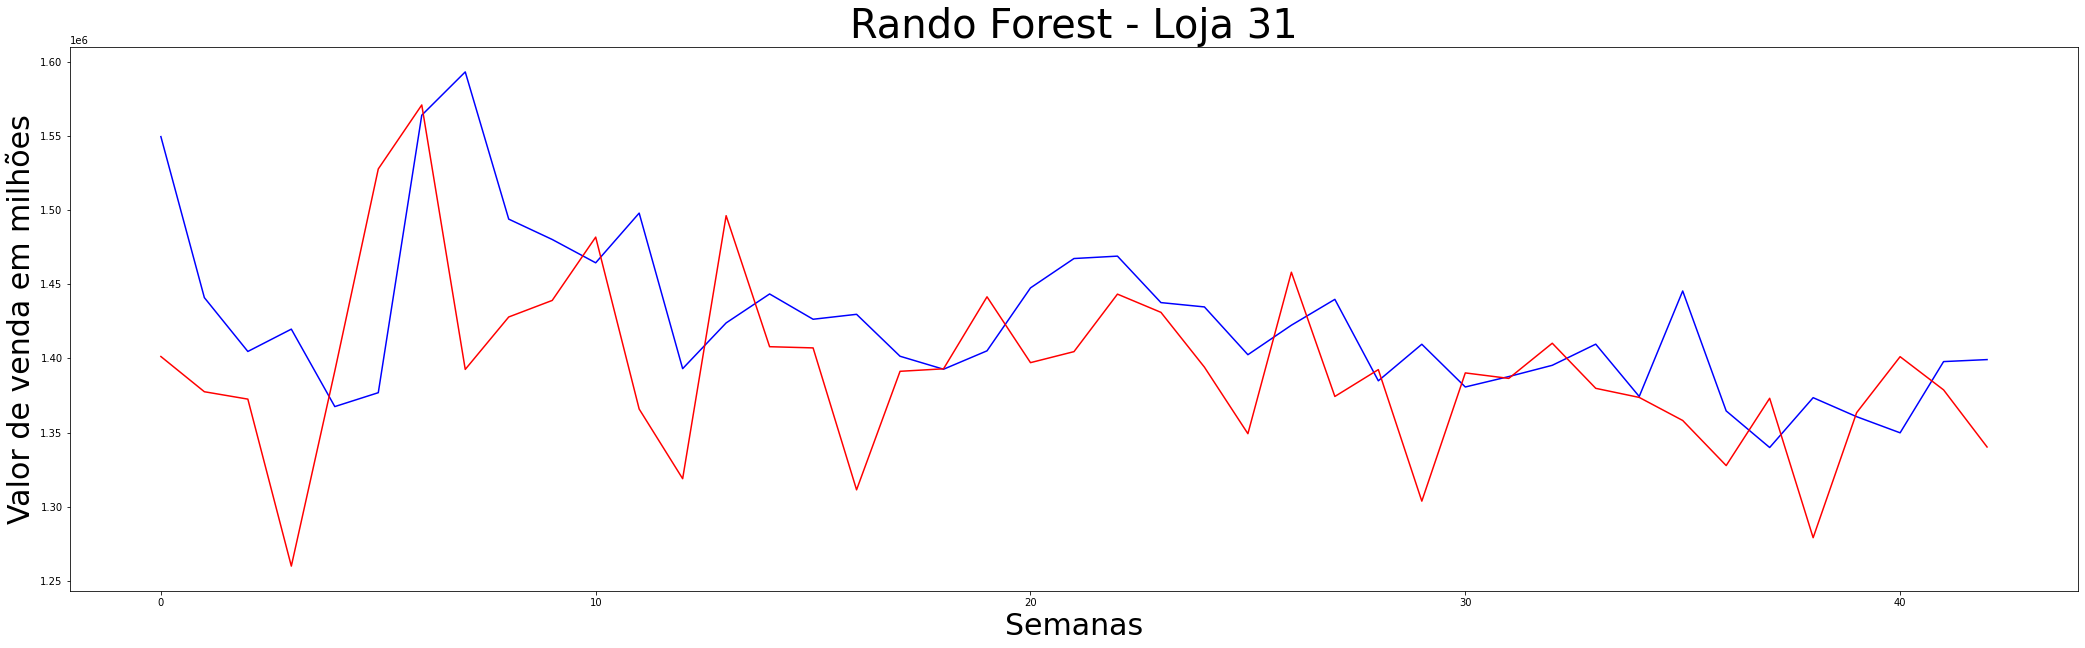

**************************************************
Resultados Loja 32:
-0.5851303714632281 48722.85350405256 66617.93707023762


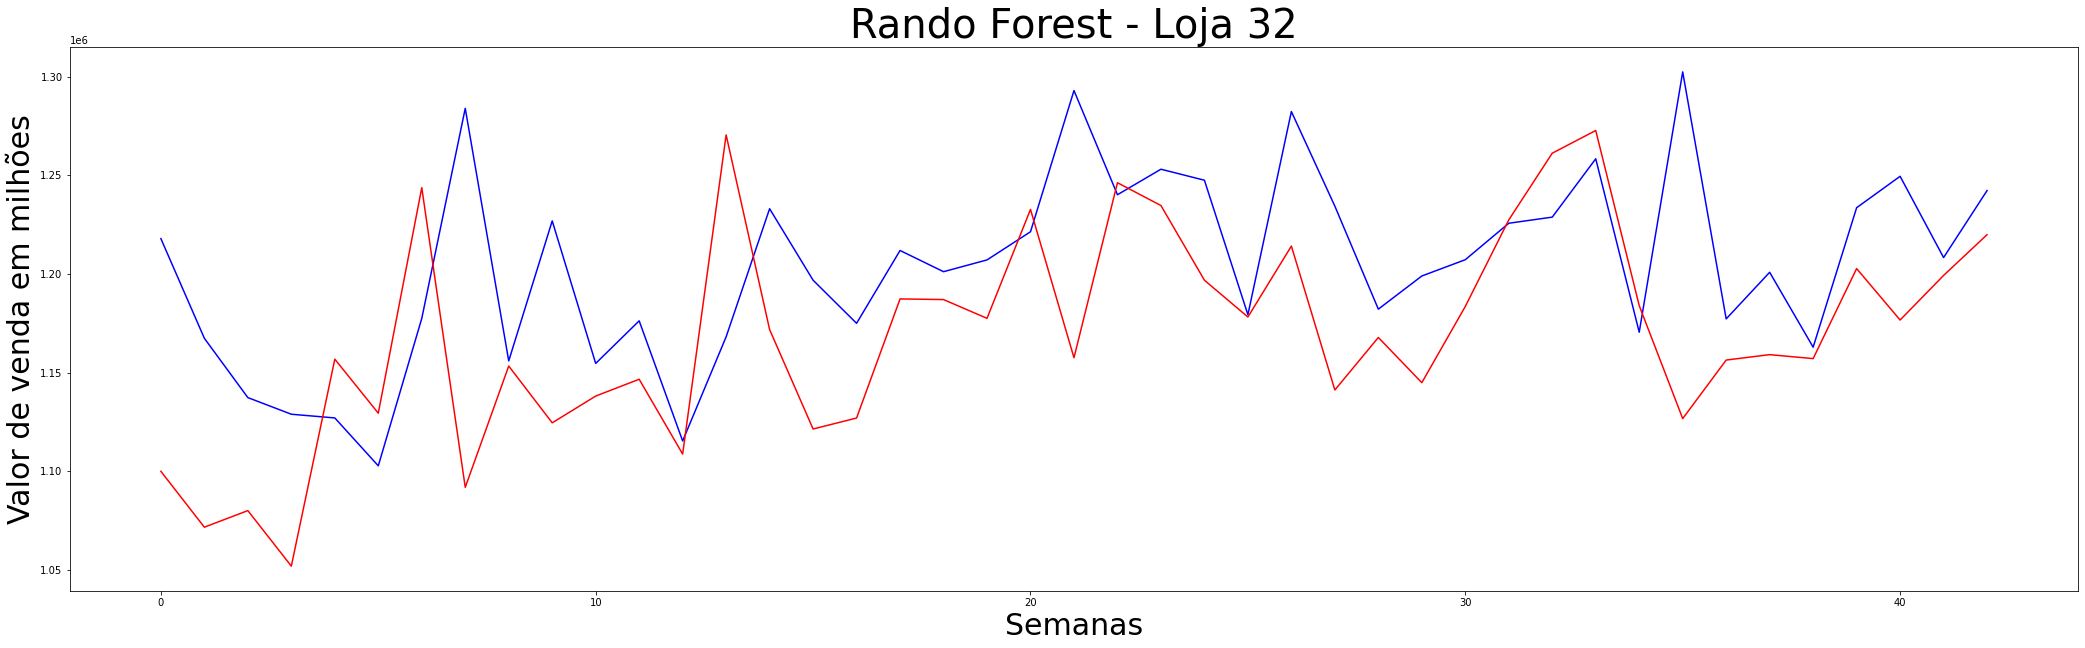

**************************************************
Resultados Loja 33:
-0.07165800468528061 15475.287377687067 18961.595980787257


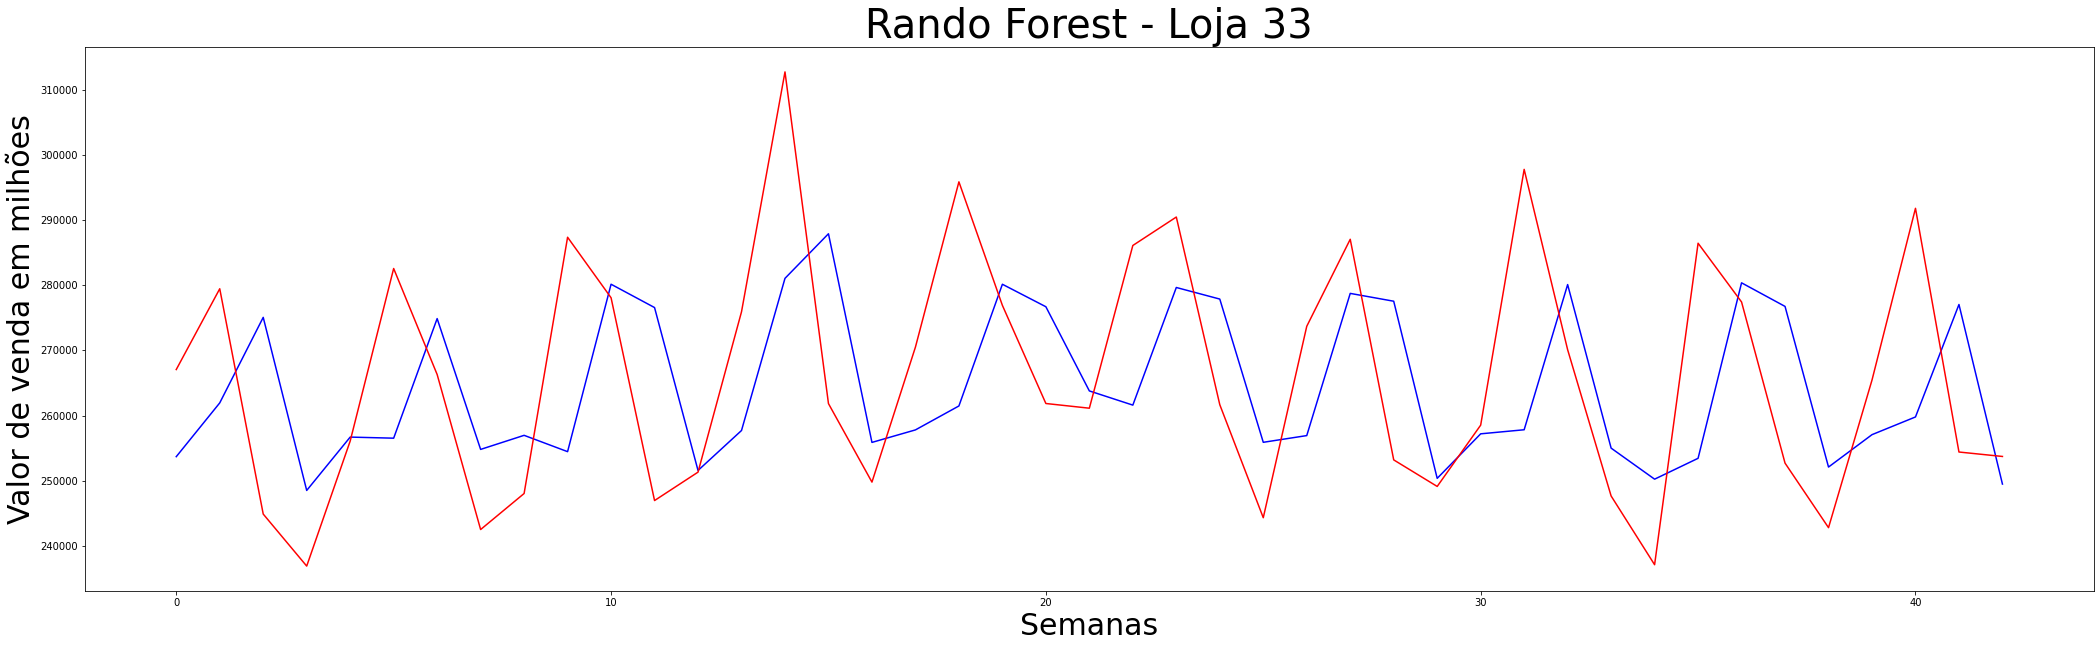

**************************************************
Resultados Loja 34:
-0.10651914572422094 37818.12389883549 47339.80730593026


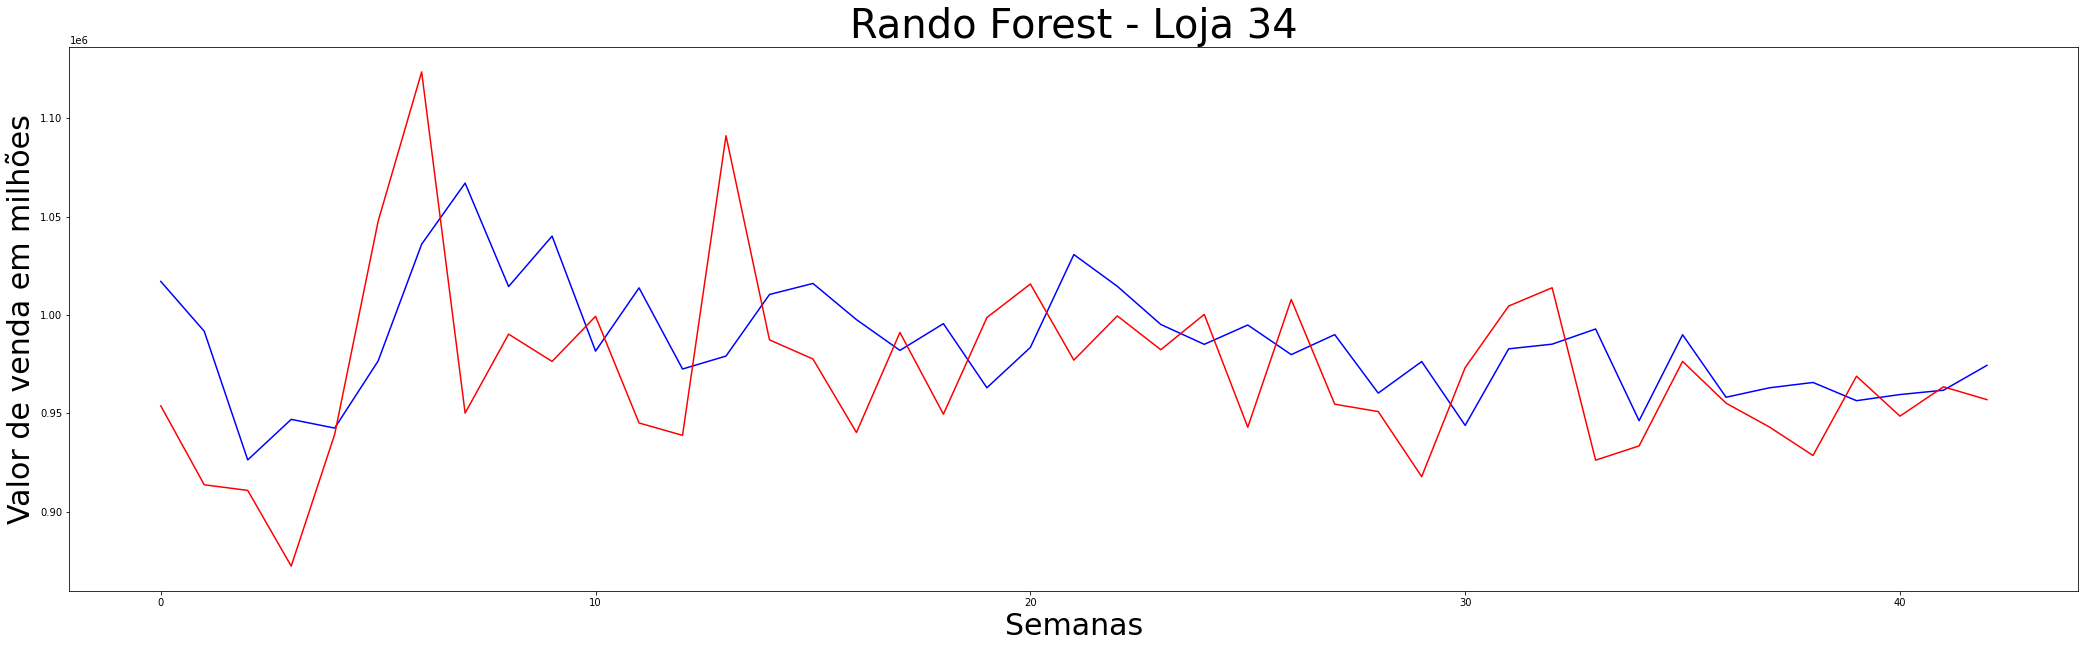

**************************************************
Resultados Loja 35:
0.1255465266598328 51953.60622873362 77505.58931707717


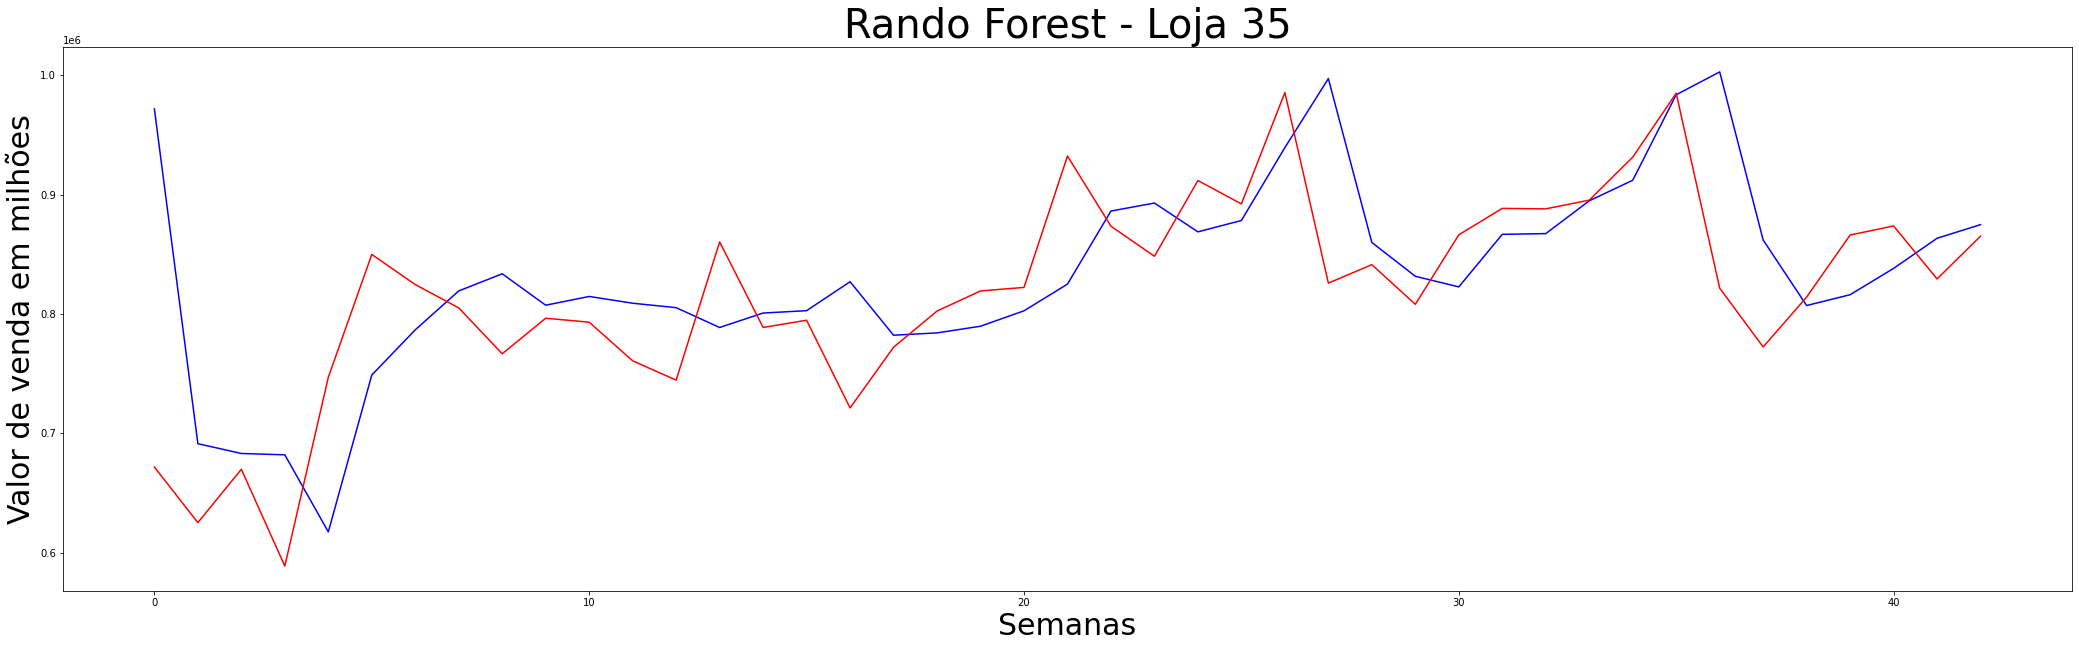

**************************************************
Resultados Loja 36:
0.03963794633726325 14309.736923854043 18164.299881559687


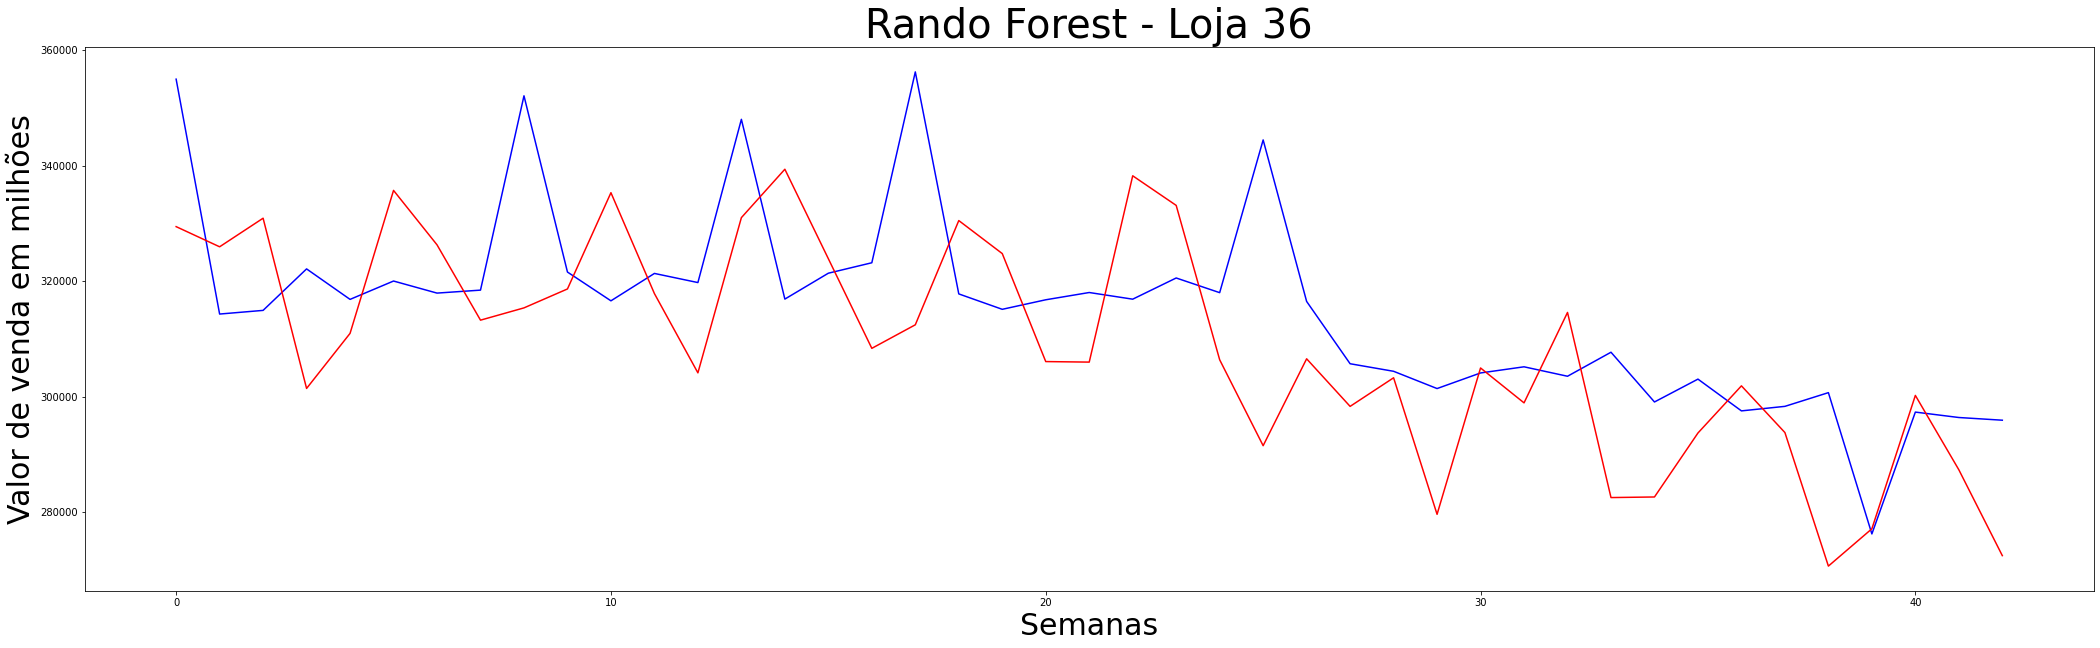

**************************************************
Resultados Loja 37:
-0.2764498293522317 14851.267122959234 19738.126251944435


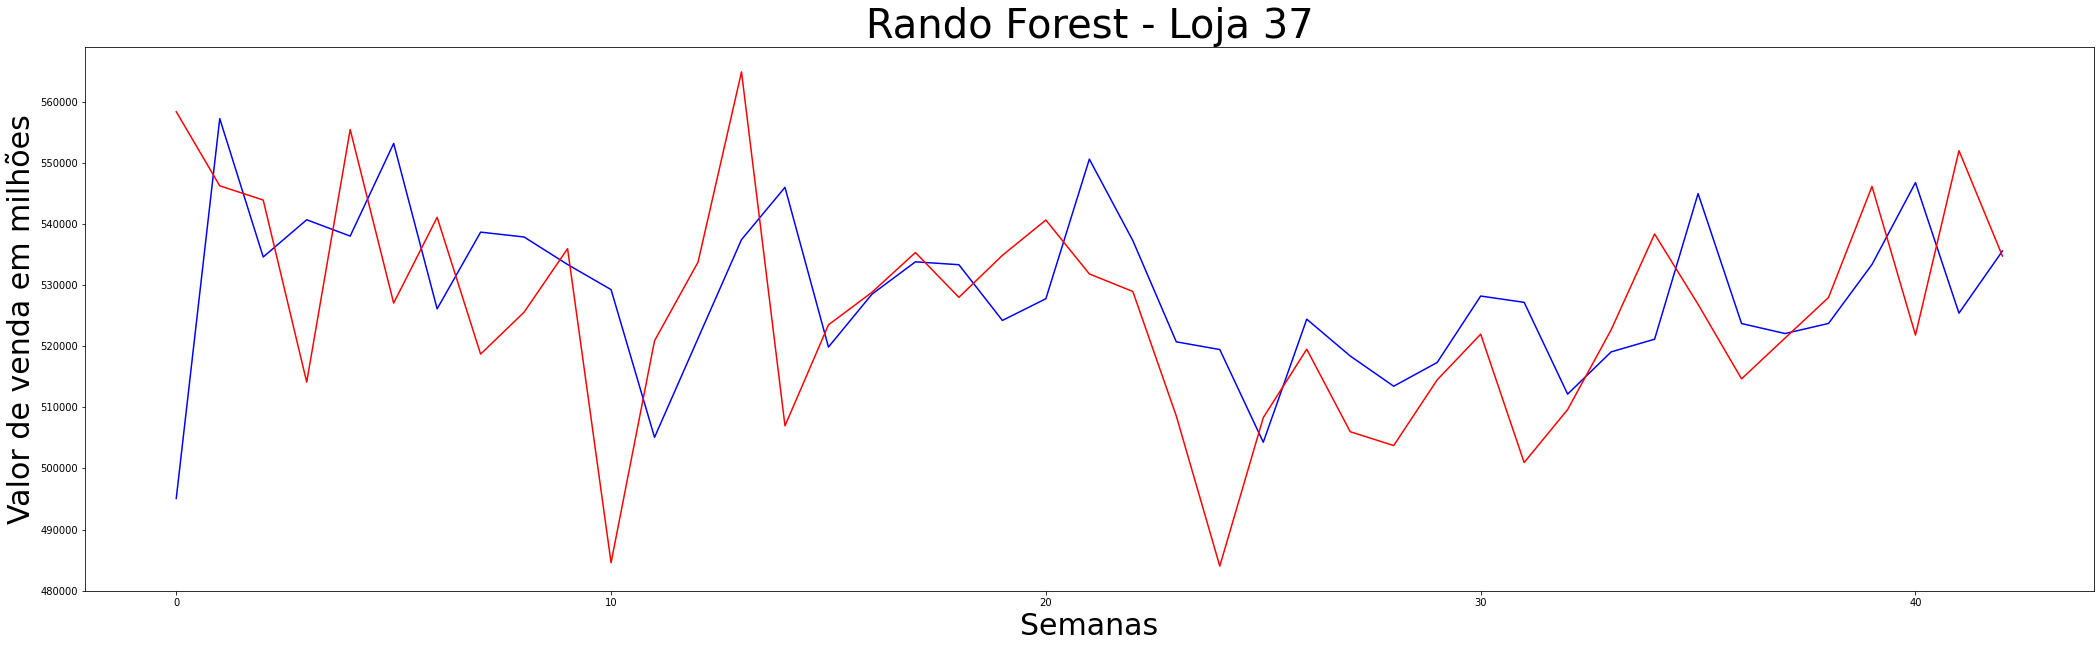

**************************************************
Resultados Loja 38:
-1.3493478790541875 34812.370900077454 41757.93037399609


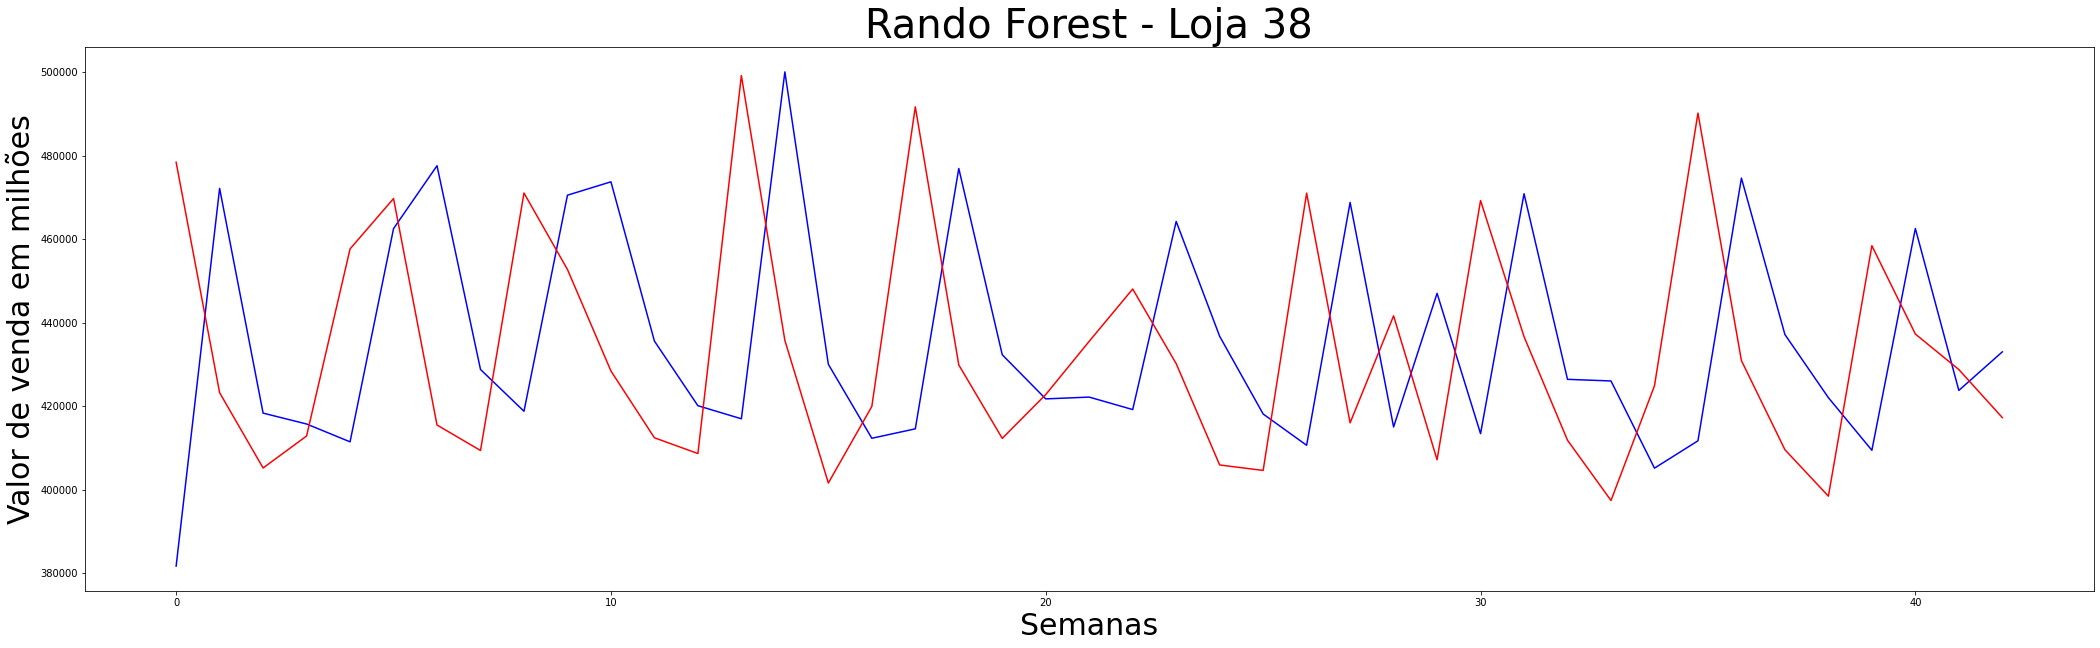

**************************************************
Resultados Loja 39:
0.1671394378385972 73966.59295173135 90495.02224018324


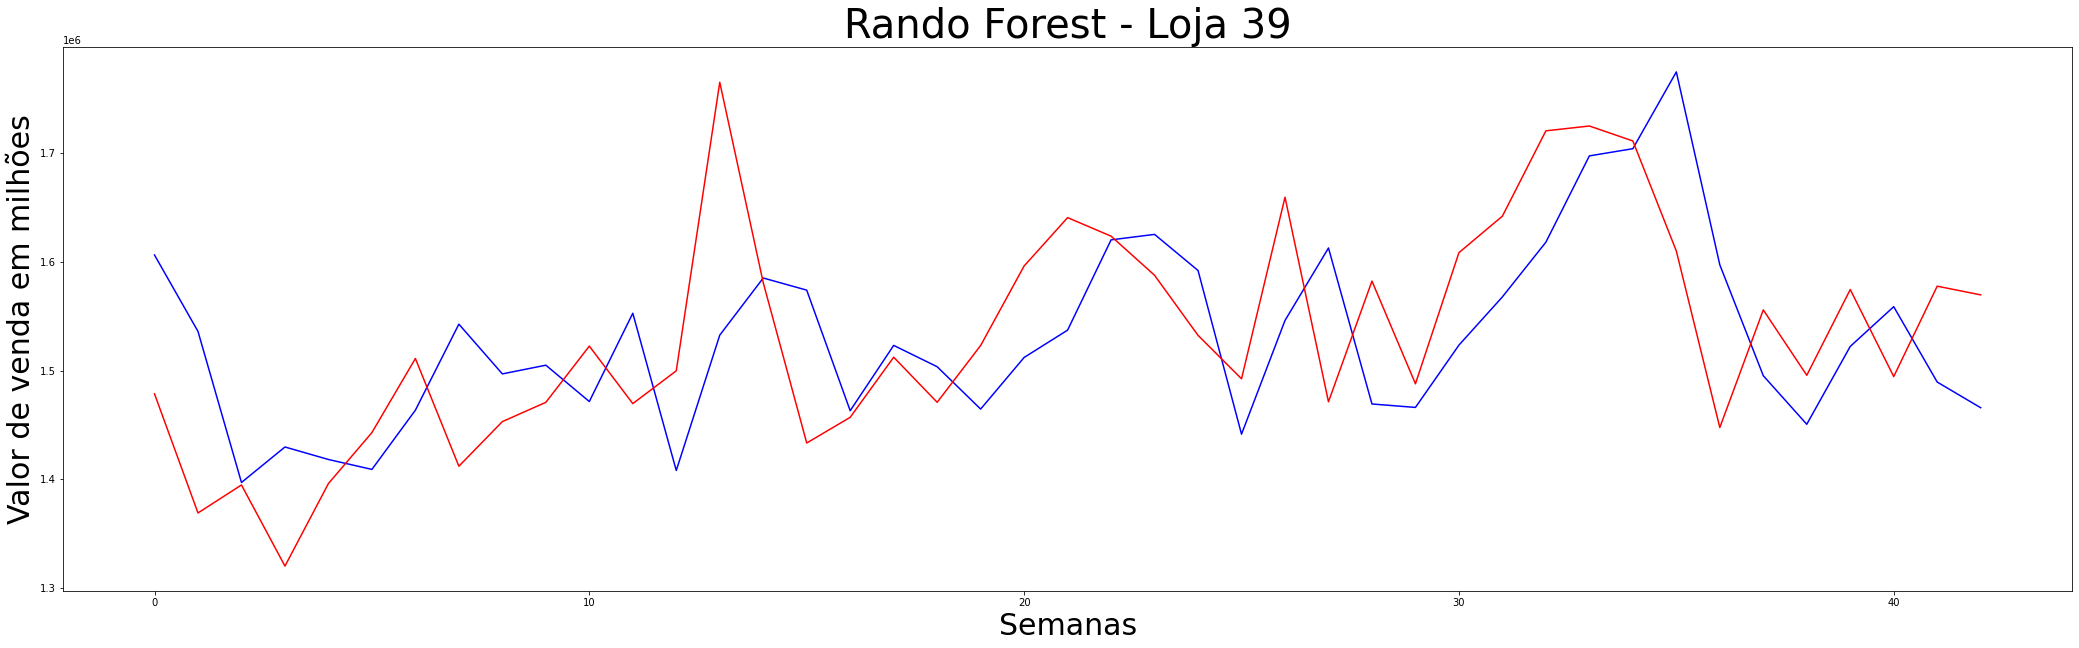

**************************************************
Resultados Loja 40:
0.0018407325100117111 65307.5736612103 84975.1841542622


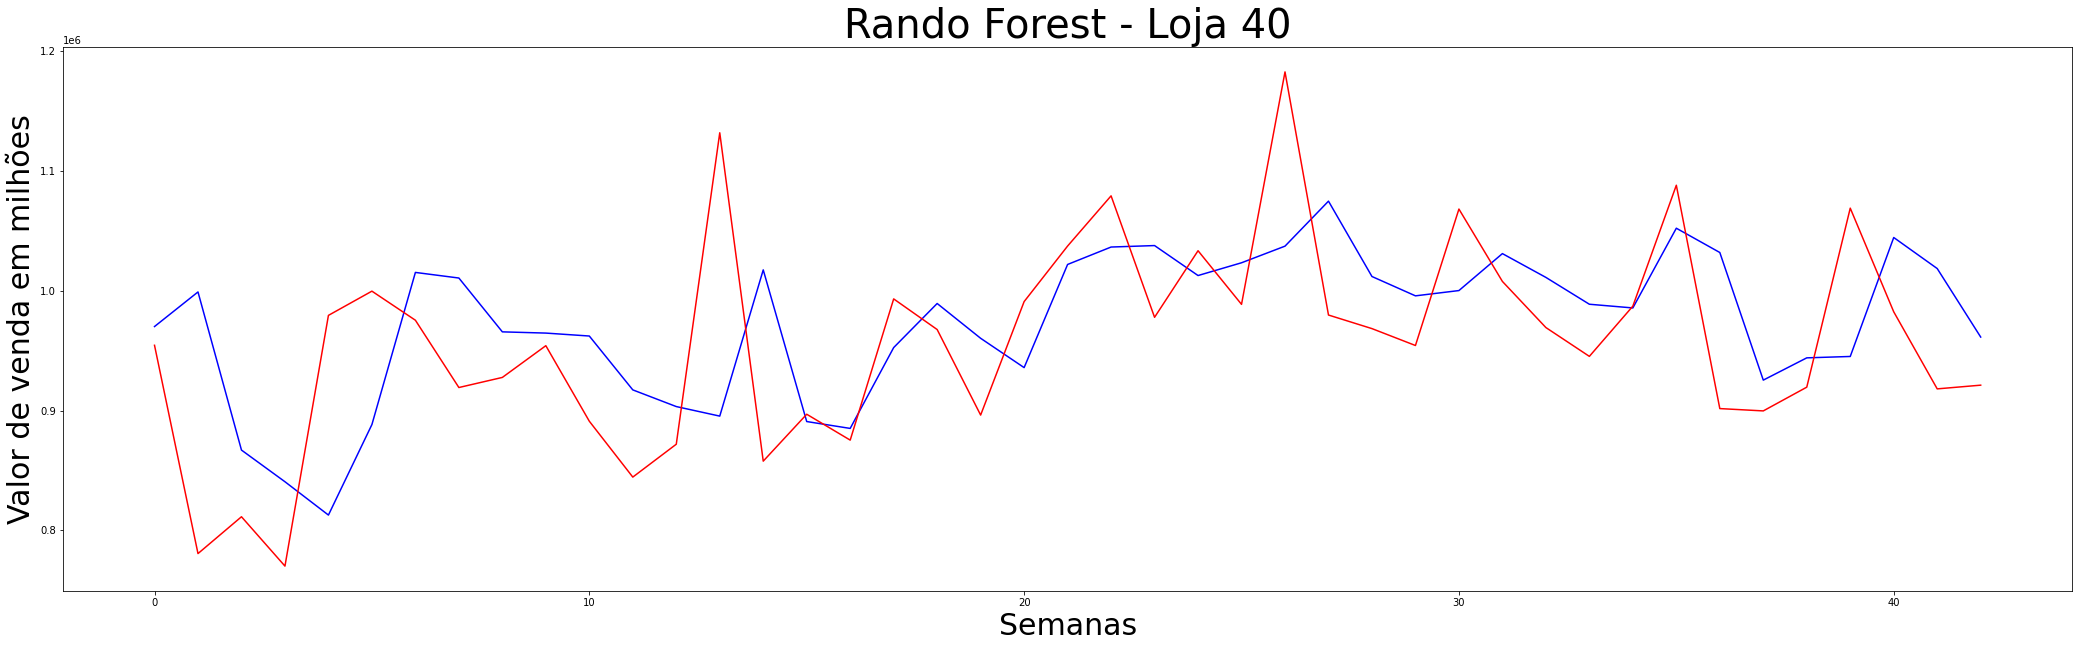

**************************************************
Resultados Loja 41:
0.2433971041313956 67569.52950496154 90267.69724013543


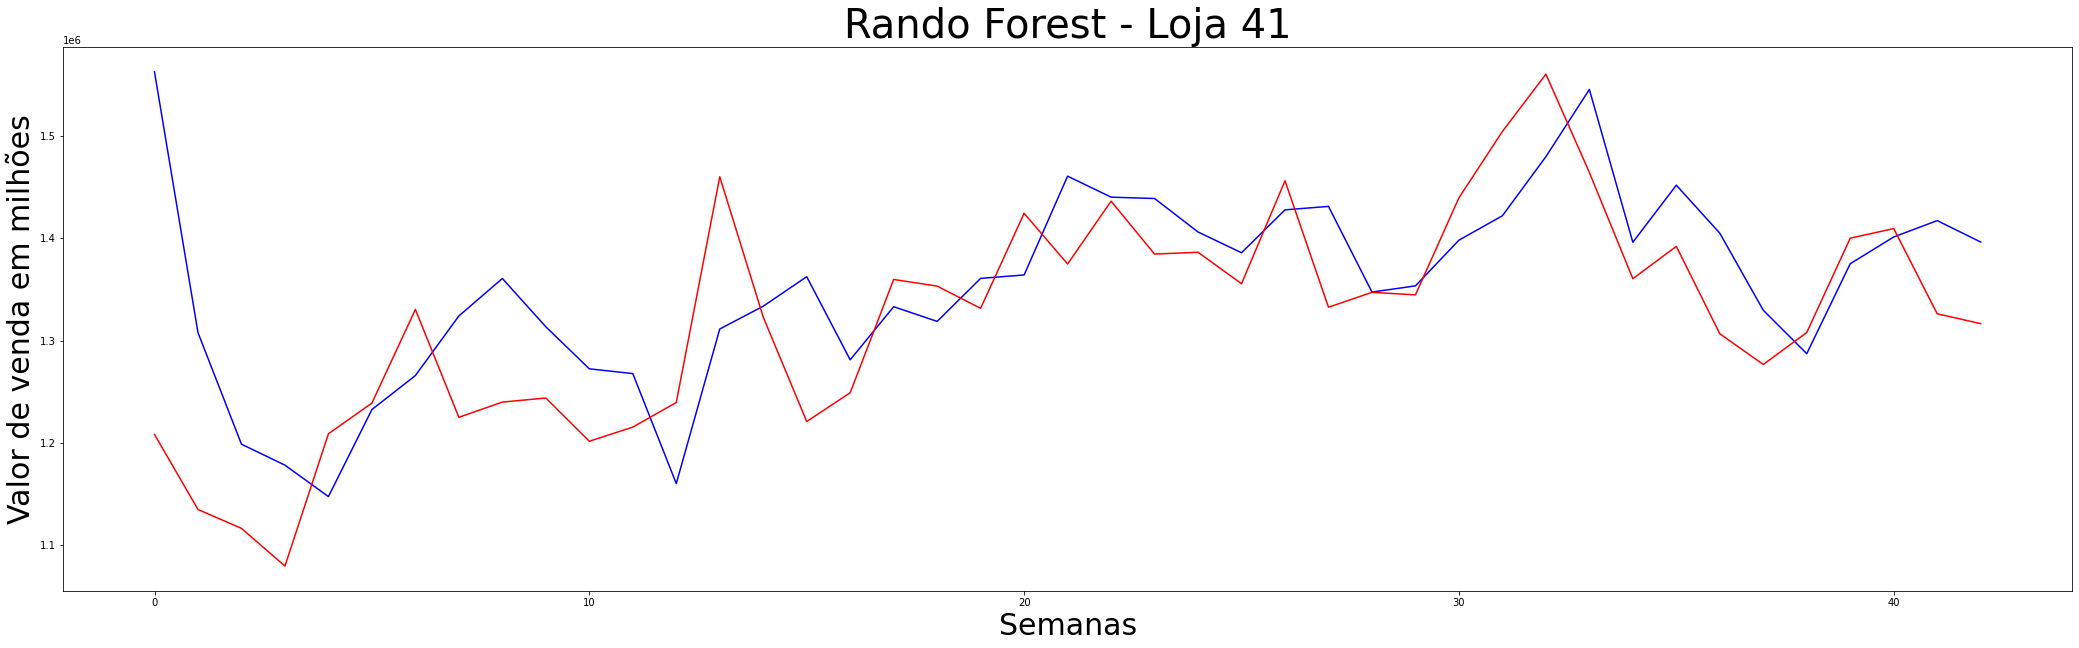

**************************************************
Resultados Loja 42:
-0.013058615334259116 40636.03665078367 48640.83924090535


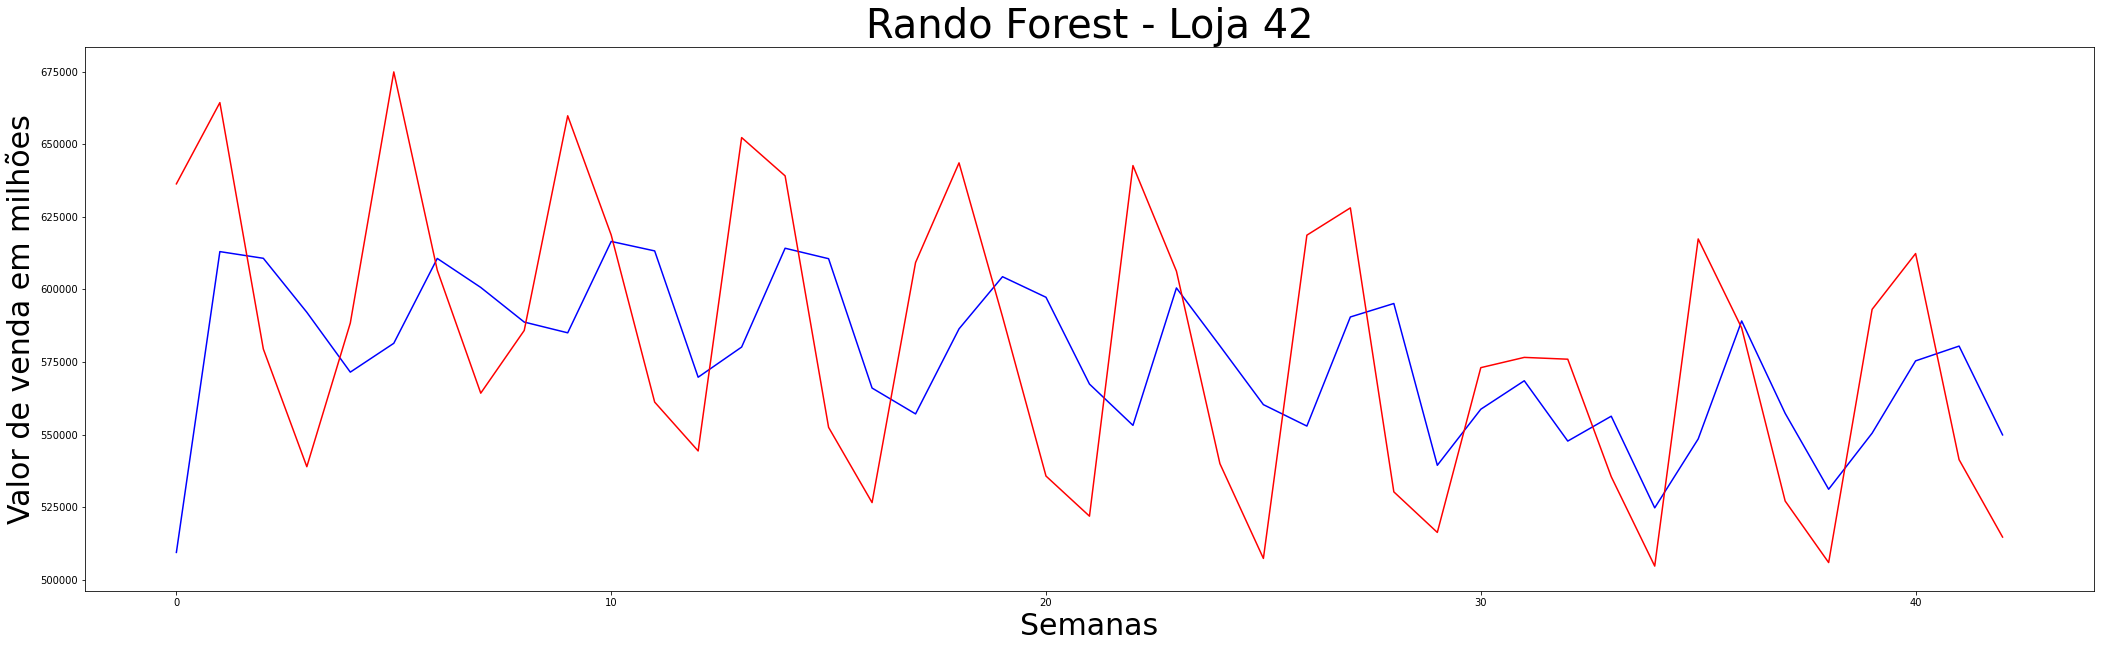

**************************************************
Resultados Loja 43:
-0.6938069820910673 28759.10186318008 36610.46849571986


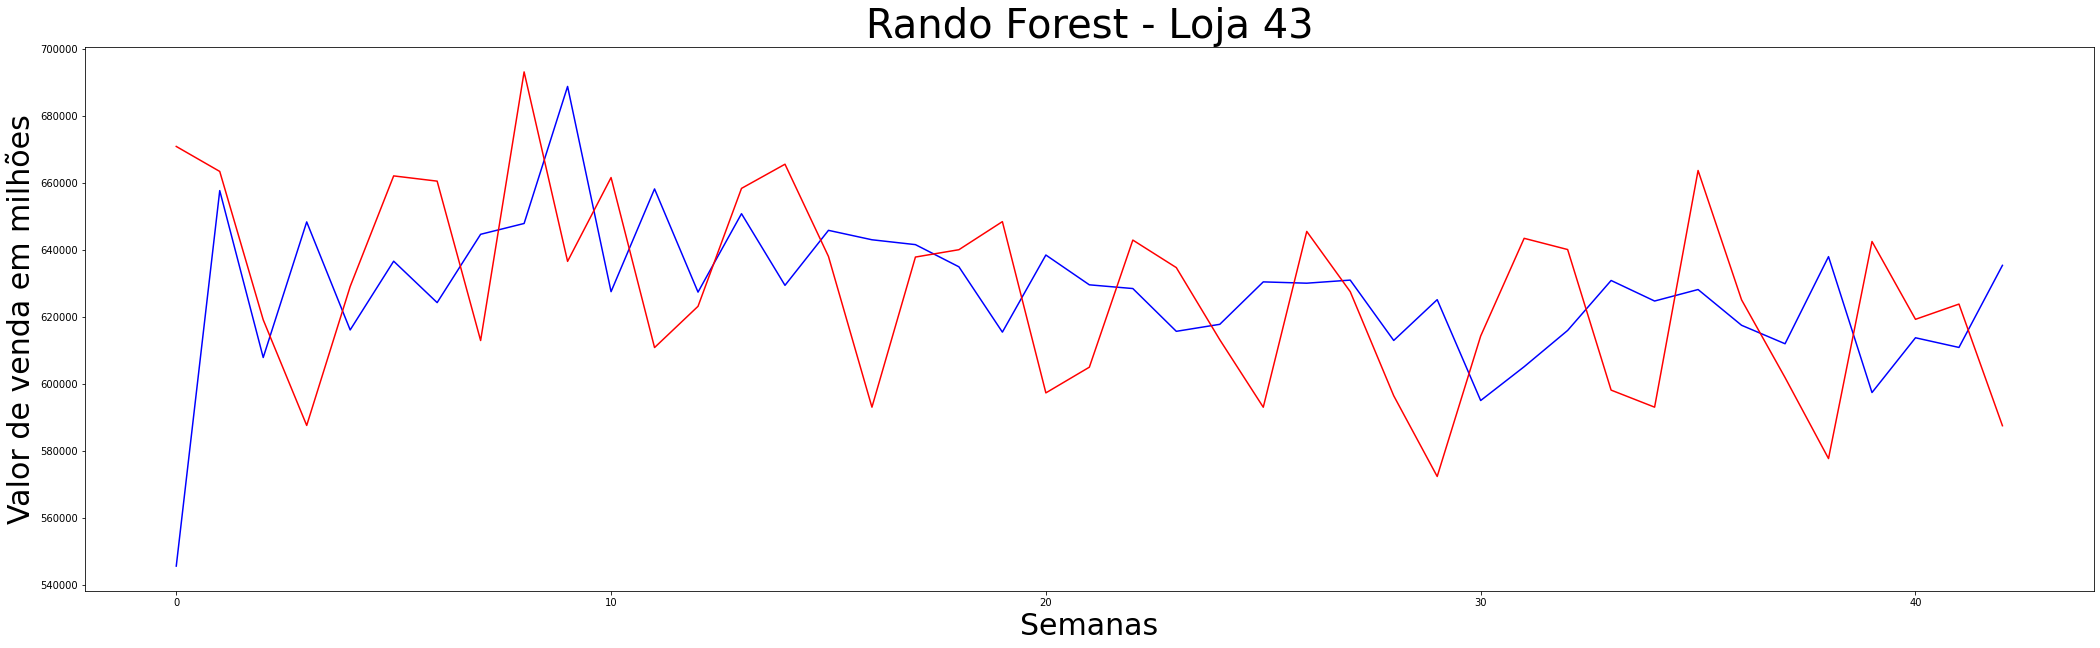

**************************************************
Resultados Loja 44:
-0.8839038588267931 15723.979383595164 19149.15012895948


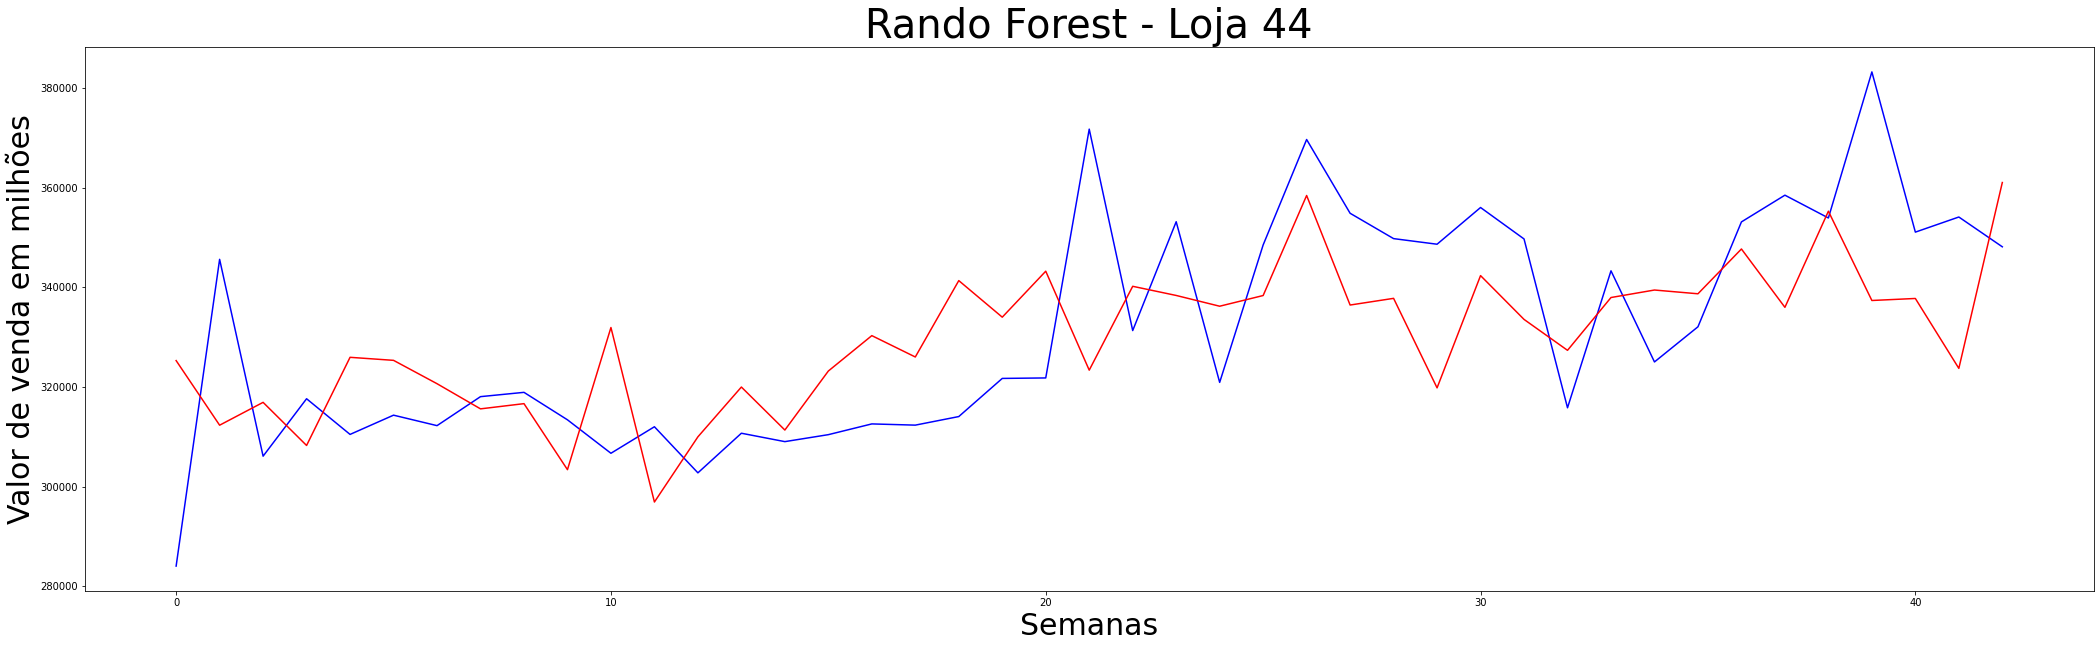

**************************************************
Resultados Loja 45:
-0.565452264056419 46067.0435062458 64585.47533855639


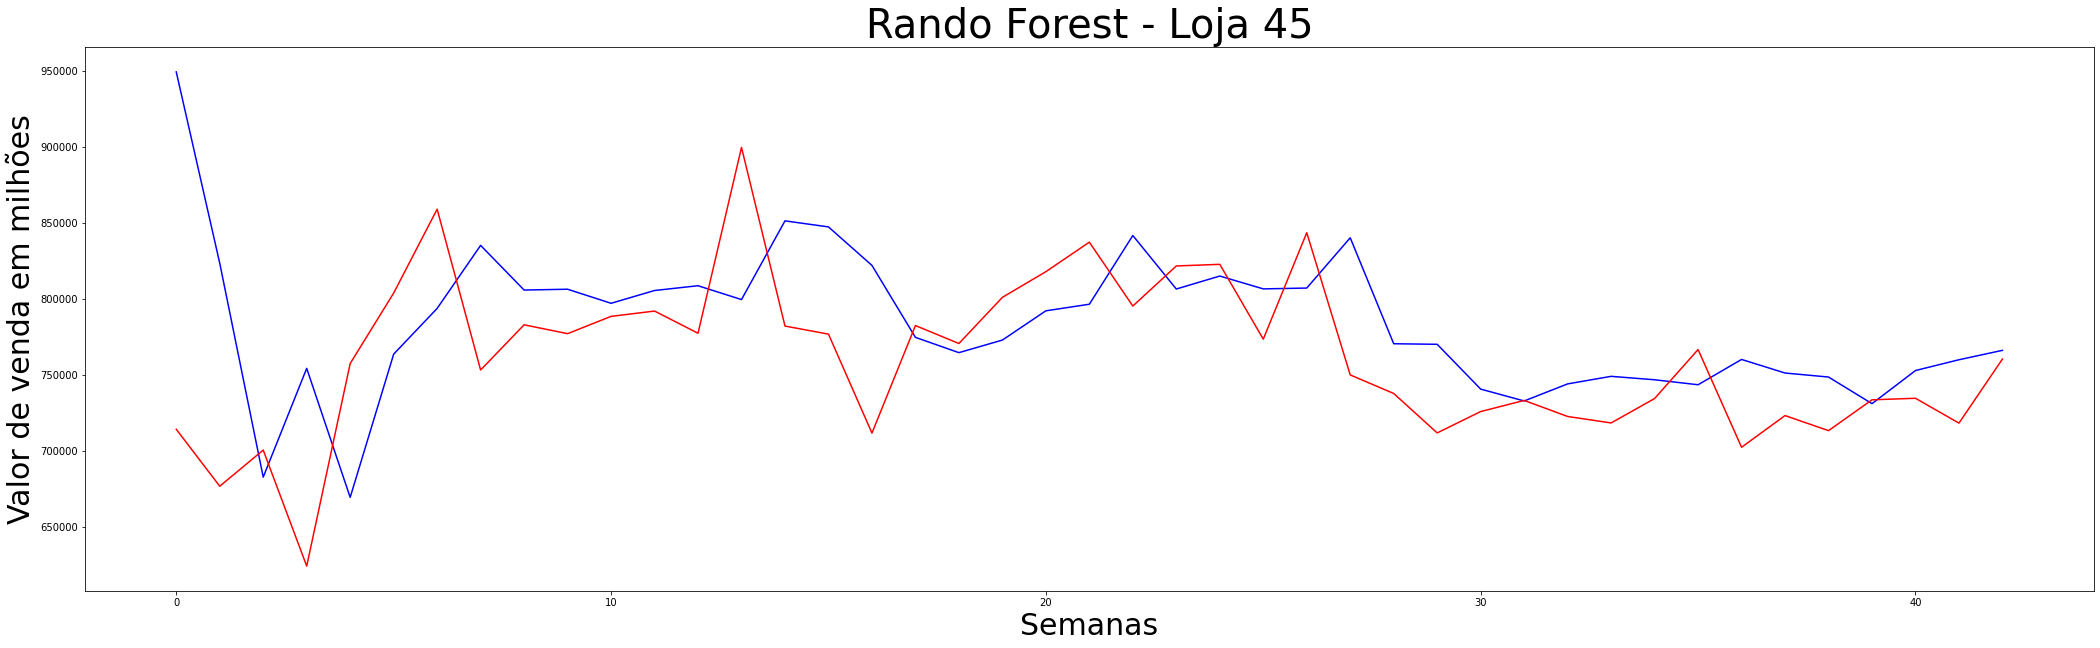

**************************************************


In [14]:
Xy_test = X_test
Xy_test["y"] = y_test

for i in range(1, 46):
  X_loja = Xy_test.where(Xy_test["Store_" + str(i)] == 1).dropna()
  y_loja = X_loja["y"]
  X_loja = X_loja.drop(["y"], axis=1)

  predictions_loja = rf.predict(X_loja)

  print("Resultados Loja {}:".format(i))
  print(r2_score(y_loja, predictions_loja), mean_absolute_error(y_loja, predictions_loja), np.sqrt(mean_squared_error(y_loja, predictions_loja)))
  
  plt.figure(figsize = (36, 10)) 
  plt.plot(range(len(predictions_loja)), predictions_loja, 'b')
  plt.plot(range(len(predictions_loja)), y_loja, 'r')
  plt.title("Rando Forest - Loja {}".format(i), fontsize=40)
  plt.xlabel("Semanas", fontsize=30)
  plt.ylabel("Valor de venda em milhões", fontsize=30)

  plt.show()
  
  print(50*"*")
